In [207]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from matplotlib.lines import Line2D
from scipy.linalg import block_diag

sys.path.append(os.path.abspath(os.path.join('../../src')))
sys.path.append(os.path.abspath(os.path.join('../newton_based_algorithms')))

from utils import get_form_initial_conditions
try:
    from tudatpy.astro.time_conversion import DateTime
    use_tudatpy = True
except ImportError:
    print('No tudatpy available')
    use_tudatpy = False
from dynamics import SatelliteDynamics, Propagator

from unkkt import UNKKT
from tree_newton import Tree_Newton
from approxh_newton import approxH_Newton
from mm_newton import MM_Newton

try:
    from concurrent.futures import ProcessPoolExecutor
    use_several_cpus = True
except ImportError:
    print('No concurrent.futures.ProcessPoolExecutor available')
    use_several_cpus = False
use_several_cpus = True

use_causal = True

No tudatpy available


In [208]:
# Position estimation error
def position_estimation_error(X_est, X_true):
    return np.linalg.norm(X_est[:3, :, :] - X_true[:3, :, :], axis=0).flatten(), np.linalg.norm(X_est[6:9, :, :] - X_true[6:9, :, :], axis=0).flatten(), np.linalg.norm(X_est[12:15, :, :] - X_true[12:15, :, :], axis=0).flatten(), np.linalg.norm(X_est[18:21, :, :] - X_true[18:21, :, :], axis=0).flatten()

In [209]:
# Simulation parameters
dt = 60.0  # Time step [s]
T = 395  # Duration [min]

# Set simulation start (0 TDB seconds since J2000) and end epochs
if use_tudatpy:
    simulation_start_epoch = DateTime(2000, 1, 1).epoch()
    simulation_end_epoch = (T - 1) * dt

T_RMSE = 300  # Index from which the RMSE is calculated
M = 1  # Number of Monte-Carlo simulations
N = 4  # Number of satellites
formation = 1
n_x = 6  # State dimension
n_p = 3  
n_y_1 = 3 
n_y_2 = 2
n_y_3 = 2
n_y_4 = 2
K = T
W = 20 # Window size [min]

In [210]:
# Initial state vector and get the true state vectors
X_initial = get_form_initial_conditions(formation)
if use_tudatpy:
    propagator = Propagator(simulation_start_epoch, simulation_end_epoch, dt, X_initial)
    X_true = propagator.run().T.reshape(24, 1, T)
else:
    X_true = np.zeros((24, 1, T))
    X_true[:, :, 0] = X_initial
    for t in range(T - 1):
        X_true[:, :, t + 1] = SatelliteDynamics().x_new(dt, X_true[:, :, t])

In [211]:
if use_tudatpy:
    # Estimate process noise
    X_our_model = np.zeros((24, 1, T))
    X_our_model[:, :, 0] = X_initial
    for t in range(T - 1):
        X_our_model[:, :, t + 1] = SatelliteDynamics().x_new(dt, X_true[:, :, t])

    # Compute the difference between the ground truth and the model after initial conditions
    diff = X_true[:, :, 1:] - X_our_model[:, :, 1:]
    diff_flattened = diff.T.reshape(-1, 24)

    # Calculate the general covariance matrix of the flattened differences
    Q = np.cov(diff_flattened, rowvar=False)

    # Create a zero matrix of the same shape
    Q_modified = np.zeros_like(Q)

    # Fill only the required block diagonals
    Q_modified[:6, :6] = np.diag(np.diag(Q[:6, :6]))
    Q_modified[6:12, 6:12] = np.diag(np.diag(Q[6:12, 6:12]))
    Q_modified[12:18, 12:18] = np.diag(np.diag(Q[12:18, 12:18]))
    Q_modified[18:, 18:] = np.diag(np.diag(Q[18:, 18:]))
    Q = Q_modified
    pd.DataFrame(Q[:6, :6]), pd.DataFrame(Q[6:12, 6:12]), pd.DataFrame(Q[12:18, 12:18]), pd.DataFrame(Q[18:, 18:])

In [212]:
# propagator2 = Propagator(simulation_start_epoch, simulation_end_epoch, 1.0, X_initial)
# X_true2 = propagator2.run().T.reshape(24, 1, 23641)

# # Estimate process noise
# X_our_model2 = np.zeros((24, 1, 23641))
# X_our_model2[:, :, 0] = X_initial
# for t in range(23641 - 1):
#     X_our_model2[:, :, t + 1] = SatelliteDynamics().x_new(1.0, X_true2[:, :, t])

# # Compute the difference between the ground truth and the model after initial conditions
# diff2 = X_true2[:, :, 1:] - X_our_model2[:, :, 1:]
# diff_flattened2 = diff2.T.reshape(-1, 24)

# # Calculate the general covariance matrix of the flattened differences
# Q2 = np.cov(diff_flattened2, rowvar=False)

# # Create a zero matrix of the same shape
# Q_modified2 = np.zeros_like(Q2)

# # Fill only the required block diagonals
# Q_modified2[:6, :6] = np.diag(np.diag(Q2[:6, :6]))
# Q_modified2[6:12, 6:12] = np.diag(np.diag(Q2[6:12, 6:12]))
# Q_modified2[12:18, 12:18] = np.diag(np.diag(Q2[12:18, 12:18]))
# Q_modified2[18:, 18:] = np.diag(np.diag(Q2[18:, 18:]))
# Q2 = Q_modified2
# pd.DataFrame(Q2[:6, :6]), pd.DataFrame(Q2[6:12, 6:12]), pd.DataFrame(Q2[12:18, 12:18]), pd.DataFrame(Q2[18:, 18:])

In [213]:
# Observation noise
r_chief_pos = 1e-1  # [m]
R_chief = np.diag(np.concatenate([r_chief_pos * np.ones(3)])) ** 2
r_deputy_pos = 1e0  # [m]
R_deputies = np.diag(np.concatenate([r_deputy_pos * np.ones(6)])) ** 2
R = block_diag(R_chief, R_deputies)

# Initial deviation noise
p_pos_initial = 1e2  # [m]
p_vel_initial = 1e-2  # [m / s]
P = np.array([[1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0]])

In [214]:
tol = 1e-20
max_iter = 100

# Declare solvers
unkkt = UNKKT(W, R_chief, r_deputy_pos)
unkkt.grad_tol = tol
unkkt.max_iter = max_iter

tree_newton = Tree_Newton(W, R_chief, r_deputy_pos)
tree_newton.grad_tol = tol
tree_newton.max_iter = max_iter

approxh_newton = approxH_Newton(W, R_chief, r_deputy_pos)
approxh_newton.grad_tol = tol
approxh_newton.max_iter = max_iter

mm_newton = MM_Newton(W, R_chief, r_deputy_pos)
mm_newton.grad_tol = tol
mm_newton.max_iter = 10
mm_newton.mm_tol = tol
mm_newton.mm_max_iter = 10

In [215]:
# Simulation setup
np.random.seed(42)

X_est = np.zeros_like(X_true)
initial_dev = np.concatenate(
    (
        p_pos_initial * np.random.randn(3, 1),
        p_vel_initial * np.random.randn(3, 1),
        p_pos_initial * np.random.randn(3, 1),
        p_vel_initial * np.random.randn(3, 1),
        p_pos_initial * np.random.randn(3, 1),
        p_vel_initial * np.random.randn(3, 1),
        p_pos_initial * np.random.randn(3, 1),
        p_vel_initial * np.random.randn(3, 1),
    )
)
X_est[:, :, 0] = X_initial + initial_dev
for t in range(T - 1):
    X_est[:, :, t + 1] = SatelliteDynamics().x_new(dt, X_est[:, :, t])

# Observations
Y = np.zeros((9, 1, T))
for t in range(T):
    Y[:, :, t] = unkkt.h(X_true[:, :, t]) + np.random.normal(0, np.sqrt(np.diag(R)).reshape((9, 1)), size=(9, 1))
    
dev_chief_initial = np.linalg.norm(X_est[:3, :, :] - X_true[:3, :, :], axis=0).reshape(-1, 1)
dev_deputy1_initial = np.linalg.norm(X_est[6:9, :, :] - X_true[6:9, :, :], axis=0).reshape(-1, 1)
dev_deputy2_initial = np.linalg.norm(X_est[12:15, :, :] - X_true[12:15, :, :], axis=0).reshape(-1, 1)
dev_deputy3_initial = np.linalg.norm(X_est[18:21, :, :] - X_true[18:21, :, :], axis=0).reshape(-1, 1)

dev_chief_initial, dev_deputy1_initial, dev_deputy2_initial, dev_deputy3_initial = position_estimation_error(X_est, X_true)

In [216]:
if not use_several_cpus:
    # SEQUENTIAL USING ONE CPU
    # Main execution loop
    for m in tqdm(range(M), desc="MC runs", leave=True):
        # Observations
        Y = np.zeros((9, 1, T))
        for t in range(T):
            Y[:, :, t] = unkkt.h(X_true[:, :, t]) + np.random.multivariate_normal(np.zeros(9), R).reshape((9, 1))

        # Estimate the state
        X_est_unkkt = X_initial + initial_dev
        X_est_tree_newton = X_initial + initial_dev
        X_est_approx_newton = X_initial + initial_dev
        X_est_mm = X_initial + initial_dev
        for n in tqdm(range(W - 1, K), desc="Windows", leave=False): # n is the index of the end of the finite-horizon window
            print("-------- Centralized Newton --------")
            X_est_unkkt = unkkt.solve_for_each_window(dt, X_est_unkkt, Y[:, :, n - W + 1 : n + 1])
            print(f"Final position relative errors: {np.linalg.norm(X_true[:3, :, n - W + 1] - X_est_unkkt[:3])} m, {np.linalg.norm(X_true[6:9, :, n - W + 1] - X_est_unkkt[6:9])} m, {np.linalg.norm(X_true[12:15, :, n - W + 1] - X_est_unkkt[12:15])} m, {np.linalg.norm(X_true[18:21, :, n - W + 1] - X_est_unkkt[18:21])} m")
            print("-------- Tree Newton --------")
            X_est_tree_newton = tree_newton.solve_for_each_window(dt, X_est_tree_newton, Y[:, :, n - W + 1 : n + 1], X_true[:, :, n - W + 1])
            print("-------- ApproxH Newton --------")
            X_est_approx_newton = approxh_newton.solve_for_each_window(dt, X_est_approx_newton, Y[:, :, n - W + 1 : n + 1], X_true[:, :, n - W + 1])
            print("-------- MM Newton --------")
            X_est_mm = mm_newton.solve_for_each_window(dt, X_est_mm, Y[:, :, n - W + 1 : n + 1], X_true[:, :, n - W + 1])

            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(2 * 6.4, 4.8))

            # First subplot - Cost function values
            ax1.plot(unkkt.cost_function_values, '.-', label='Centralized Newton')
            ax1.plot(tree_newton.cost_function_values, '.-', label='Tree Newton')
            ax1.plot(approxh_newton.cost_function_values, '.-', label='ApproxH Newton')
            ax1.plot(mm_newton.cost_function_values, '.-', label='MM Newton Cost Function')
            ax1.plot(mm_newton.surrogate_function_values, '.-', label='MM Newton Surrogate Function')
            ax1.set_xlabel('Iteration')
            ax1.set_ylabel('$\frac{1}{H}$ Cost Function')
            ax1.set_yscale('log')
            ax1.grid(True)
            ax1.legend()

            # Second subplot - Gradient norm values
            ax2.plot(unkkt.grad_norm_values, '.-', label='Centralized Newton')
            ax2.plot(tree_newton.grad_norm_values, '.-', label='Tree Newton')
            ax2.plot(approxh_newton.grad_norm_values, '.-', label='ApproxH Newton')
            ax2.plot(mm_newton.grad_norm_values, '.-', label='MM Newton Cost Function Gradient Norm')
            ax2.plot(mm_newton.surrogate_grad_norm_values, '.-', label='MM Newton Surrogate Function Gradient Norm')
            ax2.set_xlabel('Iteration')
            ax2.set_ylabel('$\frac{1}{H}$Gradient Norm')
            ax2.set_yscale('log')
            ax2.grid(True)
            ax2.legend()

            plt.title(f'Window {n + 1}')
            plt.tight_layout()
            plt.show()
            
            unkkt.cost_function_values = []
            unkkt.grad_norm_values = []
            tree_newton.cost_function_values = []
            tree_newton.grad_norm_values = []
            approxh_newton.cost_function_values = []
            approxh_newton.grad_norm_values = []
            mm_newton.cost_function_values = []
            mm_newton.grad_norm_values = []
            mm_newton.surrogate_function_values = []
            mm_newton.surrogate_grad_norm_values = []
            
            X_est_unkkt = unkkt.dynamic_model.x_new(dt, X_est_unkkt)
            X_est_tree_newton = tree_newton.dynamic_model.x_new(dt, X_est_tree_newton)
            X_est_approx_newton = approxh_newton.dynamic_model.x_new(dt, X_est_approx_newton)
            X_est_mm = mm_newton.dynamic_model.x_new(dt, X_est_mm)

In [217]:
if use_several_cpus and not use_causal:
    # DISTRIBUTED OVER SEVERAL CPUs AND NONCAUSAL
    
    # Initialize storage arrays for state estimates
    X_est_unkkt_history = np.zeros((24, 1, K))  # Centralized Newton
    X_est_tree_newton_history = np.zeros((24, 1, K))  # Tree Newton
    X_est_approx_newton_history = np.zeros((24, 1, K))  # ApproxH Newton
    X_est_mm_history = np.zeros((24, 1, K))  # MM Newton
    
    def solve_algorithm(algorithm_name, algorithm, X_est, dt, Y, X_true, n):
        """
        Solves the estimation problem for a given algorithm.
        Returns the algorithm name, updated X_est, and cost function/gradient data for plotting.
        """
        print(f"-------- {algorithm_name} --------")
        
        if algorithm_name == "Centralized Newton":
            X_est = algorithm.solve_for_each_window(dt, X_est, Y[:, :, n : n + W])
            final_errors = [
                np.linalg.norm(X_true[:3, :, n] - X_est[:3]),
                np.linalg.norm(X_true[6:9, :, n] - X_est[6:9]),
                np.linalg.norm(X_true[12:15, :, n] - X_est[12:15]),
                np.linalg.norm(X_true[18:21, :, n] - X_est[18:21])
            ]
            print(f"Final position relative errors: {final_errors} m")
        
        elif algorithm_name in ["Tree Newton", "ApproxH Newton", "MM Newton"]:
            X_est = algorithm.solve_for_each_window(dt, X_est, Y[:, :, n : n + W], X_true[:, :, n])
    
        # Collect cost function and gradient norm data
        return (
            algorithm_name,
            X_est,
            algorithm.cost_function_values.copy(),
            algorithm.grad_norm_values.copy(),
            algorithm.surrogate_function_values.copy() if hasattr(algorithm, "surrogate_function_values") else [],
            algorithm.surrogate_grad_norm_values.copy() if hasattr(algorithm, "surrogate_grad_norm_values") else []
        )
    
    # ================= MAIN EXECUTION =================
    for m in tqdm(range(M), desc="MC runs", leave=True):
        # Generate observations
        Y = np.zeros((9, 1, T))
        for t in range(T):
            Y[:, :, t] = unkkt.h(X_true[:, :, t]) + np.random.multivariate_normal(np.zeros(9), R).reshape((9, 1))
    
        # Initialize state estimates
        X_est_unkkt = X_initial + initial_dev
        X_est_tree_newton = X_initial + initial_dev
        X_est_approx_newton = X_initial + initial_dev
        X_est_mm = X_initial + initial_dev
    
        for n in tqdm(range(K - W + 1), desc="Windows", leave=False):
            with ProcessPoolExecutor(max_workers=4) as executor:
                # Run each algorithm in parallel
                future_to_algorithm = {
                    executor.submit(solve_algorithm, "Centralized Newton", unkkt, X_est_unkkt, dt, Y, X_true, n): "Centralized Newton",
                    executor.submit(solve_algorithm, "Tree Newton", tree_newton, X_est_tree_newton, dt, Y, X_true, n): "Tree Newton",
                    executor.submit(solve_algorithm, "ApproxH Newton", approxh_newton, X_est_approx_newton, dt, Y, X_true, n): "ApproxH Newton",
                    executor.submit(solve_algorithm, "MM Newton", mm_newton, X_est_mm, dt, Y, X_true, n): "MM Newton"
                }
    
                # Retrieve results in the main process
                results = {future.result()[0]: future.result()[1:] for future in future_to_algorithm}
    
            # Extract updated estimates
            X_est_unkkt, cost_unkkt, grad_unkkt, _, _ = results["Centralized Newton"]
            X_est_tree_newton, cost_tree, grad_tree, _, _ = results["Tree Newton"]
            X_est_approx_newton, cost_approx, grad_approx, _, _ = results["ApproxH Newton"]
            X_est_mm, cost_mm, grad_mm, surrogate_cost_mm, surrogate_grad_mm = results["MM Newton"]
            
            # Store X_est history per algorithm
            X_est_unkkt_history[:, :, n] = X_est_unkkt
            X_est_tree_newton_history[:, :, n] = X_est_tree_newton
            X_est_approx_newton_history[:, :, n] = X_est_approx_newton
            X_est_mm_history[:, :, n] = X_est_mm
    
            # Plot results **in the main process**
            fig, axs = plt.subplots(1, 3, figsize=(3 * 6.4, 4.8))
    
            # Cost function values
            axs[0].plot(cost_unkkt, '.-', label='Centralized Newton')
            axs[0].plot(cost_tree, '.-', label='Tree Newton (original)')
            axs[0].plot(cost_approx, '.-', label='ApproxH Newton')
            axs[0].plot(cost_mm, '.-', label='MM Newton Cost Function')
            axs[0].plot(surrogate_cost_mm, '.-', label='MM Newton Surrogate Function')
            axs[0].set_xlabel('Iteration')
            axs[0].set_ylabel(r'$\frac{1}{H}$ Cost Function')
            axs[0].set_yscale('log')
            axs[0].grid(True)
            axs[0].legend()
    
            # Gradient norm values
            axs[1].plot(grad_unkkt, '.-', label='Centralized Newton')
            axs[1].plot(grad_tree, '.-', label='Tree Newton')
            axs[1].plot(grad_approx, '.-', label='ApproxH Newton')
            axs[1].plot(grad_mm, '.-', label='MM Newton Cost Function Gradient Norm')
            axs[1].plot(surrogate_grad_mm, '.-', label='MM Newton Surrogate Function Gradient Norm')
            axs[1].set_xlabel('Iteration')
            axs[1].set_ylabel(r'$\frac{1}{H}$ Gradient Norm')
            axs[1].set_yscale('log')
            axs[1].grid(True)
            axs[1].legend()

            # Initialize storage for current estimates
            X_est_unkkt_current = np.zeros((24, 1, W))
            X_est_tree_newton_current = np.zeros((24, 1, W))
            X_est_approx_newton_current = np.zeros((24, 1, W))
            X_est_mm_current = np.zeros((24, 1, W))
            
            # Simulate forward propagation over the window
            X_est_unkkt_current[:, :, 0] = X_est_unkkt
            X_est_tree_newton_current[:, :, 0] = X_est_tree_newton
            X_est_approx_newton_current[:, :, 0] = X_est_approx_newton
            X_est_mm_current[:, :, 0] = X_est_mm
            
            for tau in range(W - 1):
                X_est_unkkt_current[:, :, tau + 1] = unkkt.dynamic_model.x_new(dt, X_est_unkkt_current[:, :, tau])
                X_est_tree_newton_current[:, :, tau + 1] = tree_newton.dynamic_model.x_new(dt, X_est_tree_newton_current[:, :, tau])
                X_est_approx_newton_current[:, :, tau + 1] = approxh_newton.dynamic_model.x_new(dt, X_est_approx_newton_current[:, :, tau])
                X_est_mm_current[:, :, tau + 1] = mm_newton.dynamic_model.x_new(dt, X_est_mm_current[:, :, tau])
            
            # Compute position estimation errors
            dev_chief_unkkt_current, dev_deputy1_unkkt_current, dev_deputy2_unkkt_current, dev_deputy3_unkkt_current = position_estimation_error(X_est_unkkt_current, X_true[:, :, n:n + W])
            dev_chief_tree_current, dev_deputy1_tree_current, dev_deputy2_tree_current, dev_deputy3_tree_current = position_estimation_error(X_est_tree_newton_current, X_true[:, :, n:n + W])
            dev_chief_approxh_current, dev_deputy1_approxh_current, dev_deputy2_approxh_current, dev_deputy3_approxh_current = position_estimation_error(X_est_approx_newton_current, X_true[:, :, n:n + W])
            dev_chief_mm_current, dev_deputy1_mm_current, dev_deputy2_mm_current, dev_deputy3_mm_current = position_estimation_error(X_est_mm_current, X_true[:, :, n:n + W])
            
            # Define colors for algorithms
            algorithm_colors = {
                'Initial guess': 'grey',
                'Centralized Newton': 'C0',
                'Tree Newton': 'C1',
                'ApproxH Newton': 'C2',
                'MM Newton': 'C3'
            }
            
            # Define markers for different agents (i = 1, ..., 4)
            markers = ['.', '^', '2', 's', 'P']
            
            # Plot Initial Guess deviations (use the same color for all i)
            for i, dev_initial in enumerate([dev_chief_initial, dev_deputy1_initial, dev_deputy2_initial, dev_deputy3_initial]):
                axs[2].plot(dev_initial[n:n + W - 1], linestyle='-', color=algorithm_colors['Initial guess'], marker=markers[i])
            
            # Plot Centralized Newton deviations
            for i, dev_unkkt in enumerate([dev_chief_unkkt_current, dev_deputy1_unkkt_current, dev_deputy2_unkkt_current, dev_deputy3_unkkt_current]):
                axs[2].plot(dev_unkkt, linestyle='-', color=algorithm_colors['Centralized Newton'], marker=markers[i])
            
            # Plot Tree Newton deviations
            for i, dev_tree in enumerate([dev_chief_tree_current, dev_deputy1_tree_current, dev_deputy2_tree_current, dev_deputy3_tree_current]):
                axs[2].plot(dev_tree, linestyle='-', color=algorithm_colors['Tree Newton'], marker=markers[i])
            
            # Plot ApproxH Newton deviations
            for i, dev_approxh in enumerate([dev_chief_approxh_current, dev_deputy1_approxh_current, dev_deputy2_approxh_current, dev_deputy3_approxh_current]):
                axs[2].plot(dev_approxh, linestyle='-', color=algorithm_colors['ApproxH Newton'], marker=markers[i])
            
            # Plot MM Newton deviations
            for i, dev_mm in enumerate([dev_chief_mm_current, dev_deputy1_mm_current, dev_deputy2_mm_current, dev_deputy3_mm_current]):
                axs[2].plot(dev_mm, linestyle='-', color=algorithm_colors['MM Newton'], marker=markers[i])
            
            # Set axis labels and scale
            axs[2].set_xlabel(r'$\tau$')
            axs[2].set_ylabel(r'$\left\|\hat{\mathbf{p}}_i(\tau) - \mathbf{p}_i(\tau)\right\|$ [m]')
            axs[2].set_yscale('log')
            axs[2].grid(True)
            
            # Create legend (Colors for Algorithms, Markers for Agents)
            legend_elements = [
                Line2D([0], [0], linestyle='-', color=algorithm_colors['Initial guess'], label='Initial guess'),
                Line2D([0], [0], linestyle='-', color=algorithm_colors['Centralized Newton'], label='Centralized Newton'),
                Line2D([0], [0], linestyle='-', color=algorithm_colors['Tree Newton'], label='Tree Newton'),
                Line2D([0], [0], linestyle='-', color=algorithm_colors['ApproxH Newton'], label='ApproxH Newton'),
                Line2D([0], [0], linestyle='-', color=algorithm_colors['MM Newton'], label='MM Newton'),
                Line2D([0], [0], linestyle='', marker='.', color='black', label='$i = 1$'),
                Line2D([0], [0], linestyle='', marker='^', color='black', label='$i = 2$'),
                Line2D([0], [0], linestyle='', marker='2', color='black', label='$i = 3$'),
                Line2D([0], [0], linestyle='', marker='s', color='black', label='$i = 4$')
            ]
            fig.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
    
            fig.suptitle(f'Window k = {n}')
            plt.tight_layout() 
            plt.show()
    
            # Update state estimates
            X_est_unkkt = unkkt.dynamic_model.x_new(dt, X_est_unkkt)
            X_est_tree_newton = tree_newton.dynamic_model.x_new(dt, X_est_tree_newton)
            X_est_approx_newton = approxh_newton.dynamic_model.x_new(dt, X_est_approx_newton)
            X_est_mm = mm_newton.dynamic_model.x_new(dt, X_est_mm)

Windows:   0%|          | 0/391 [00:00<?, ?it/s]

-------- Centralized Newton ---------------- Tree Newton ---------------- ApproxH Newton --------


Before applying the algorithm
Cost function: 408161.0506927258
Gradient norm: 1039876.8917802242
Global relative error: 395.60563949432424Before applying the algorithm
Cost function: 408161.0506927258
Gradient norm: 1039092.3408769941
Global relative error: 395.60563949432424Before applying the algorithm
L_norm = 408161.0506927258
Grad_L_norm = 1039876.8917802242



Position relative errors: 82.78540989608044 m, 181.7491507333766 m, 258.73787052498585 m, 222.8729633755392 m
Position relative errors: 82.78540989608044 m, 181.7491507333766 m, 258.73787052498585 m, 222.8729633755392 m


Iteration 1
Cost function: 11177069.496573009 (2638.40%)
Gradient norm: 1354597.6957979745 (30.27%)
Global relative error: 635.6442407517535 (60.68%)Iteration 1
L_norm = 372957.715740888
Grad_L_norm = 230782.51330872174


Position relative errors: 2.272599481811074 m, 102.71214249593902 m, 342.78734809939334

/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=5.28291e-18): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 47
L_norm = 3.320833766626553
Grad_L_norm = 0.009650048651884312

Iteration 47
Cost function: 3229332.1026105867 (-34.90%)
Gradient norm: 440456.6623513262 (109.70%)
Global relative error: 5435.283284631775 (-29.06%)
Position relative errors: 38.48096859132458 m, 3029.285449740636 m, 3260.8002210474456 m, 3119.3117600564674 m

Iteration 48
Cost function: 2661819.8149356786 (-0.06%)
Gradient norm: 29.517434424047277 (370.21%)
Global relative error: 2455.63980600627 (0.28%)
Position relative errors: 0.13044020764341188 m, 55.86348201315708 m, 919.6384211692465 m, 2276.2343683708323 m

Iteration 48
L_norm = 3.5894759004219723
Grad_L_norm = 175.28843211841848

Iteration 48
Cost function: 1052460.3432791606 (-67.41%)
Gradient norm: 157171.48054189133 (-64.32%)
Global relative error: 4595.309706935969 (-15.45%)
Position relative errors: 22.895811662209038 m, 2598.4564726062154 m, 2623.4153255709066 m, 2735.2089979066614 m

Iteration 49
Cost function: 2668191.3944697613 (0.24%)
Grad

/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=3.57721e-18): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 51
L_norm = 3.320704975967627
Grad_L_norm = 7.541093100870716e-05

Iteration 52
Cost function: 2822152.597034776 (-2.14%)
Gradient norm: 7.555891102327282 (-99.78%)
Global relative error: 2477.0635542289915 (-0.77%)Iteration 51
Cost function: 155073.53558300895 (-75.92%)
Gradient norm: 59171.81080830831 (-76.09%)
Global relative error: 2696.7838140823387 (-5.92%)

Position relative errors: 0.13044020579258825 m, 55.863482012874975 m, 919.5755728591312 m, 2299.355919155405 m
Position relative errors: 4.528992932537588 m, 1564.2902303464375 m, 1562.7484816323877 m, 1543.7522150123475 m




/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=2.04525e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 52
L_norm = 3.3207327116006207
Grad_L_norm = 1.8047658153430814

Iteration 53
Cost function: 2820762.0676877787 (-0.05%)
Gradient norm: 0.8788987834110198 (-88.37%)
Global relative error: 2477.7056758814747 (0.03%)Iteration 52
Cost function: 470860.23075525445 (203.64%)
Gradient norm: 217605.63564303014 (267.75%)
Global relative error: 2597.8323779488383 (-3.67%)

Position relative errors: 0.13044020771993733 m, 55.86348198774252 m, 919.5755777000427 m, 2300.0476765569397 m
Position relative errors: 2.8370597463748077 m, 1508.1357904662434 m, 1492.290141424818 m, 1499.0400596288523 m




/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=7.04852e-20): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 53
L_norm = 3.3207041985389196
Grad_L_norm = 1.7042812336829897e-06

Iteration 54
Cost function: 2822076.71760464 (0.05%)
Gradient norm: 0.27843092583531925 (-68.32%)
Global relative error: 2478.1052036635188 (0.02%)Iteration 53
Cost function: 174123.30215805743 (-63.02%)
Gradient norm: 114188.07865986913 (-47.53%)
Global relative error: 2479.9117245584926 (-4.54%)

Position relative errors: 0.1304402077454888 m, 55.86348204227325 m, 919.57557806816 m, 2300.478022635887 m
Position relative errors: 3.196715041352759 m, 1492.1364992877818 m, 1433.558508759221 m, 1366.8295524475932 m


Iteration 54
L_norm = 3.3207041986809545
Grad_L_norm = 5.875148534009121e-07


/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=5.71929e-21): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)



Iteration 55
Cost function: 2823328.165591793 (0.04%)
Gradient norm: 0.49645939696066554 (78.31%)
Global relative error: 2478.13911929045 (0.00%)Iteration 54
Cost function: 5129806.662806818 (2846.08%)
Gradient norm: 855877.6231996111 (649.53%)
Global relative error: 2728.0804816529017 (10.01%)

Position relative errors: 0.1304402077232705 m, 55.86348201644818 m, 919.5755773992668 m, 2300.5145823738294 m
Position relative errors: 0.7737128202648106 m, 1374.3106074359605 m, 1330.7571101744263 m, 1944.8747906497274 m
Iteration 55
L_norm = 3.3207041976573577
Grad_L_norm = 9.973849748771689e-06





/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=1.36041e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 55
Cost function: 36991402893.555016 (721007.16%)
Gradient norm: 8286786.428851339 (868.22%)
Global relative error: 267556.2781960681 (9707.49%)Iteration 56
Cost function: 2825767.2267822707 (0.09%)
Gradient norm: 0.7147854685575072 (43.98%)
Global relative error: 2478.5422520376687 (0.02%)

Iteration 56
L_norm = 3.3207041986135204
Grad_L_norm = 7.49311695722622e-07
Position relative errors: 756.8495686495952 m, 16673.405203024675 m, 267027.5643414559 m, 1345.2868161088386 m
Position relative errors: 0.13044020775203083 m, 55.86348202823955 m, 919.5755774140081 m, 2300.948787603713 m





/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=5.82904e-20): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 57
Cost function: 2826510.124216827 (0.03%)
Gradient norm: 0.22895689039697445 (-67.97%)
Global relative error: 2478.515374748035 (-0.00%)Iteration 56
Cost function: 7664082242.34875 (-79.28%)
Gradient norm: 8634030.02207504 (4.19%)
Global relative error: 146796.02183296334 (-45.13%)Iteration 57
L_norm = 3.3207041986675336
Grad_L_norm = 8.316260875827793e-07



Position relative errors: 0.1304402077269395 m, 55.863482009080755 m, 919.5755772302778 m, 2300.919856883907 m
Position relative errors: 1007.3180655790412 m, 88888.82873079139 m, 4427.224691207707 m, 116732.51230266981 m




/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=8.67499e-20): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 58
L_norm = 3.3207041985561196
Grad_L_norm = 6.71831644612072e-07

Iteration 58
Cost function: 2830719.767976452 (0.15%)
Gradient norm: 2.7187209839670348 (1087.44%)
Global relative error: 2478.9625350383194 (0.02%)Iteration 57
Cost function: 1707955589.3438666 (-77.71%)
Gradient norm: 4262944.483664203 (-50.63%)
Global relative error: 86303.6823129028 (-41.21%)

Position relative errors: 0.13044020775658105 m, 55.863482015310296 m, 919.575577968257 m, 2301.4015026968923 m
Position relative errors: 1237.1603961173707 m, 38556.18506436395 m, 71132.34276331954 m, 30002.168972448697 m




/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=1.31405e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 59
L_norm = 3.320704197668428
Grad_L_norm = 9.975497917017093e-06

Iteration 59
Cost function: 2830849.350349689 (0.00%)
Gradient norm: 0.019062197669999822 (-99.30%)
Global relative error: 2478.920939517143 (-0.00%)Iteration 58
Cost function: 524116989.19767016 (-69.31%)
Gradient norm: 1256949.8943009384 (-70.51%)
Global relative error: 56300.49276288851 (-34.76%)

Position relative errors: 0.13044020773178677 m, 55.863482022952226 m, 919.5755777301501 m, 2301.3567044739348 m
Position relative errors: 873.2880417150351 m, 34658.997222658196 m, 24150.544181065485 m, 37207.162777725855 m




/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=1.05145e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 60
L_norm = 3.320704198671721
Grad_L_norm = 7.04340163666938e-07

Iteration 59
Cost function: 214322400.49046233 (-59.11%)
Gradient norm: 725957.5213465303 (-42.24%)
Global relative error: 38605.08384643605 (-31.43%)Iteration 60
Cost function: 2856209.0552039174 (0.90%)
Gradient norm: 127.06847995059896 (666499.32%)
Global relative error: 2480.5355835762202 (0.07%)

Position relative errors: 588.4372485266911 m, 21256.035525118466 m, 24270.500473393975 m, 21191.404233702113 m
Position relative errors: 0.1304402077624287 m, 55.863482019244046 m, 919.5755804075536 m, 2303.0960086492964 m




/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=1.07463e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 61
L_norm = 3.3207041986273524
Grad_L_norm = 6.171829441112392e-07

Iteration 61
Cost function: 2854161.356106439 (-0.07%)
Gradient norm: 0.010365389935752927 (-99.99%)
Global relative error: 2479.973376757136 (-0.02%)Iteration 60
Cost function: 58389444517.2084 (27143.74%)
Gradient norm: 92222332.11086822 (12603.54%)
Global relative error: 100902.76869522515 (161.37%)

Position relative errors: 0.13044020774701223 m, 55.863481983883894 m, 919.5755782030086 m, 2302.490478732504 m
Position relative errors: 1159.3861429940546 m, 14682.483447422199 m, 98955.00504649471 m, 12998.442983886285 m




/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=2.96912e-20): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 62
L_norm = 3.3207041977513767
Grad_L_norm = 9.90219501745107e-06

Iteration 62
Cost function: 2871046.100212374 (0.59%)
Gradient norm: 69.43342351997376 (669758.29%)
Global relative error: 2480.635918672958 (0.03%)
Iteration 61
Cost function: 9528896359.222376 (-83.68%)
Gradient norm: 33610893.31564977 (-63.55%)
Global relative error: 55075.07687169253 (-45.42%)Position relative errors: 0.1304402077822625 m, 55.86348201708269 m, 919.575589129989 m, 2303.20423366661 m


Position relative errors: 724.3541050807597 m, 37642.13404365866 m, 9745.02753824655 m, 38986.444269724685 m


/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=5.38865e-20): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)



Iteration 63
L_norm = 3.320704198590054
Grad_L_norm = 6.425000854511312e-07

Iteration 63
Cost function: 2870034.9046638766 (-0.04%)
Gradient norm: 0.002757678568516431 (-100.00%)
Global relative error: 2480.3979969321604 (-0.01%)
Iteration 62
Cost function: 2862719008.2366343 (-69.96%)
Gradient norm: 17059323.063529808 (-49.24%)
Global relative error: 33980.752970216854 (-38.30%)Position relative errors: 0.13044020775813564 m, 55.8634820207925 m, 919.5755893766892 m, 2302.9479824866767 m


Position relative errors: 510.0159240064026 m, 15557.139442428419 m, 25994.729864851073 m, 15373.309197766663 m


/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=1.19485e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)



Iteration 64
L_norm = 3.3207041986283286
Grad_L_norm = 7.591629214221366e-07

Iteration 64
Cost function: 2883750.153669092 (0.48%)
Gradient norm: 47.03544829114703 (1705517.50%)
Global relative error: 2480.8274536407616 (0.02%)
Iteration 63
Cost function: 800445216.2376063 (-72.04%)
Gradient norm: 6756916.790245909 (-60.39%)
Global relative error: 25429.413474716923 (-25.17%)Position relative errors: 0.13044020778980428 m, 55.863482021367645 m, 919.5755936661228 m, 2303.410617992696 m


Position relative errors: 362.53798149697724 m, 15983.668173292843 m, 10864.687927486242 m, 16518.57222790931 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=5.0916e-20): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 65
L_norm = 3.3207041986577357
Grad_L_norm = 6.59345909176389e-07

Iteration 65
Cost function: 2882946.6329939715 (-0.03%)
Gradient norm: 0.0016386965940899752 (-100.00%)
Global relative error: 2480.598720034054 (-0.01%)
Iteration 64
Cost function: 247166771.21468014 (-69.12%)
Gradient norm: 3510336.1636781003 (-48.05%)
Global relative error: 16751.40066460435 (-34.13%)Position relative errors: 0.1304402077714803 m, 55.86348201526794 m, 919.5755940630164 m, 2303.164264939135 m


Position relative errors: 222.12674736663493 m, 8688.561060459306 m, 11315.751637339778 m, 8773.360471617776 m


/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=2.41671e-20): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)



Iteration 66
L_norm = 3.320704197695136
Grad_L_norm = 1.001913149290473e-05

Iteration 66
Cost function: 2885960.0644025556 (0.10%)
Gradient norm: 2.694222715042381 (164312.54%)
Global relative error: 2480.6335517692487 (0.00%)
Position relative errors: 0.13044020779412732 m, 55.86348202040437 m, 919.5755868260711 m, 2303.2018084626993 m
Iteration 65
Cost function: 5334249187.63594 (2058.16%)
Gradient norm: 25802686.852247823 (635.05%)
Global relative error: 49150.67952683103 (193.41%)



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=4.84778e-20): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Position relative errors: 284.89072645269755 m, 14711.04706470099 m, 6561.864538327305 m, 46435.02722208463 m

Iteration 67
L_norm = 3.320704198640262
Grad_L_norm = 7.132731354916866e-07

Iteration 67
Cost function: 2885916.3453532825 (-0.00%)
Gradient norm: 1.1044288952886142e-05 (-100.00%)
Global relative error: 2480.621901903021 (-0.00%)
Position relative errors: 0.13044020777143303 m, 55.86348201865979 m, 919.5755857442981 m, 2303.1892615919783 m
Iteration 66
Cost function: 662854999.6169714 (-87.57%)
Gradient norm: 8053824.844427099 (-68.79%)
Global relative error: 22115.443445378056 (-55.00%)



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=1.48988e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Position relative errors: 213.3301943120366 m, 15437.765337646324 m, 14329.74560351819 m, 6735.853750902358 m

Iteration 68
L_norm = 3.3207041986473307
Grad_L_norm = 6.895292841326253e-07

Iteration 68
Cost function: 2886419.2084751083 (0.02%)
Gradient norm: 0.07665992028306766 (694013.68%)
Global relative error: 2480.6232333154035 (0.00%)
Position relative errors: 0.13044020779661664 m, 55.86348200862488 m, 919.5755854972222 m, 2303.1906998083787 m
Iteration 67
Cost function: 126177476.52331886 (-80.96%)
Gradient norm: 2939784.4664668352 (-63.50%)
Global relative error: 13051.316066400115 (-40.99%)



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=3.81911e-20): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Position relative errors: 161.48477217883024 m, 5335.386579427409 m, 5353.86777899278 m, 10638.412169034624 m

Iteration 69
L_norm = 3.320704197666114
Grad_L_norm = 1.0013878484508132e-05

Iteration 69
Cost function: 2886417.945351569 (-0.00%)
Gradient norm: 1.0618038746203307e-05 (-99.99%)
Global relative error: 2480.622900120299 (-0.00%)
Iteration 68
Cost function: 35790327.96981978 (-71.63%)
Gradient norm: 1045158.6739092758 (-64.45%)
Global relative error: 9705.388584522403 (-25.64%)Position relative errors: 0.13044020777017515 m, 55.863482008220195 m, 919.5755855892388 m, 2303.19034091071 m


Position relative errors: 123.84738402731057 m, 6240.430043158975 m, 6101.75616339975 m, 4242.816101415229 m


/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=6.2618e-20): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)



Iteration 70
L_norm = 3.3207041985888517
Grad_L_norm = 6.793712866742218e-07

Iteration 70
Cost function: 2886418.380689936 (0.00%)
Gradient norm: 9.00477980624568e-07 (-91.52%)
Global relative error: 2480.622901108696 (0.00%)
Position relative errors: 0.13044020779560092 m, 55.86348202466612 m, 919.5755861402849 m, 2303.19034175877 m
Iteration 69
Cost function: 9273578.699208949 (-74.09%)
Gradient norm: 515758.1227982326 (-50.65%)
Global relative error: 6311.345991486658 (-34.97%)

Position relative errors: 68.87511406122687 m, 3203.1519522505027 m, 3240.8642780885443 m, 4366.215175750977 m


/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=2.10819e-20): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)



Iteration 71
L_norm = 3.320704198599711
Grad_L_norm = 6.012757346785302e-07

Iteration 71
Cost function: 2886418.3803627808 (-0.00%)
Gradient norm: 6.049729175414779e-07 (-32.82%)
Global relative error: 2480.622901299598 (0.00%)
Position relative errors: 0.13044020776976684 m, 55.86348201502653 m, 919.5755866579665 m, 2303.190341757911 m
Iteration 70
Cost function: 3410216.951334587 (-63.23%)
Gradient norm: 421291.1268493571 (-18.32%)
Global relative error: 4709.913202148614 (-25.37%)

Position relative errors: 43.18797158791833 m, 2831.0446301774073 m, 2695.6506223144042 m, 2626.682939671997 m


/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=1.22991e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)



Iteration 72
L_norm = 3.3207041985958567
Grad_L_norm = 7.673235875329806e-07

Iteration 72
Cost function: 2886418.3803045554 (-0.00%)
Gradient norm: 8.387020428391989e-07 (38.63%)
Global relative error: 2480.622901230081 (-0.00%)
Iteration 71
Cost function: 872710.9581053093 (-74.41%)
Gradient norm: 167490.11156654893 (-60.24%)
Global relative error: 3666.2553121614233 (-22.16%)Position relative errors: 0.1304402077962146 m, 55.86348201776469 m, 919.5755864730783 m, 2303.1903417567896 m


Position relative errors: 21.520537225560716 m, 2090.197325282577 m, 1943.4616061703923 m, 2301.009257811499 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=4.74584e-21): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 73
L_norm = 3.3207041976041998
Grad_L_norm = 1.0014005428511703e-05

Iteration 73
Cost function: 2886418.379853221 (-0.00%)
Gradient norm: 1.060993777332583e-05 (1165.04%)
Global relative error: 2480.6229021968434 (0.00%)
Iteration 72
Cost function: 587522.7445942007 (-32.68%)
Gradient norm: 247395.83663116727 (47.71%)
Global relative error: 3097.0393102816984 (-15.53%)Position relative errors: 0.13044020777001356 m, 55.86348201143155 m, 919.5755890776915 m, 2303.190341758237 m


Position relative errors: 8.230385566234505 m, 1780.097977663498 m, 1730.8847140582418 m, 1851.1203628526157 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=4.62983e-20): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 74
L_norm = 3.3207041986948966
Grad_L_norm = 7.576281553510804e-07

Iteration 73
Cost function: 282688.17971498694 (-51.88%)
Gradient norm: 87856.78067383259 (-64.49%)
Global relative error: 2819.6412951615816 (-8.96%)Iteration 74
Cost function: 2886418.3801298477 (0.00%)
Gradient norm: 1.1024759246573288e-05 (3.91%)
Global relative error: 2480.622902553796 (0.00%)

Position relative errors: 4.91986424363447 m, 1730.444432230195 m, 1456.5197308695847 m, 1683.515809026821 m
Position relative errors: 0.1304402077955362 m, 55.863482002833095 m, 919.5755900375117 m, 2303.190341759678 m




/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=9.92769e-21): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 75
L_norm = 3.3207041986353927
Grad_L_norm = 5.8407601010208e-07

Iteration 74
Cost function: 820034.2057103601 (190.08%)
Gradient norm: 330110.8195344671 (275.74%)
Global relative error: 2603.9064109828173 (-7.65%)Iteration 75
Cost function: 2886418.379507965 (-0.00%)
Gradient norm: 1.0591610561744574e-05 (-3.93%)
Global relative error: 2480.62290293975 (0.00%)

Position relative errors: 1.5972986894930277 m, 1538.3448931461808 m, 1411.2347809293174 m, 1556.2496948684181 m
Position relative errors: 0.1304402077706174 m, 55.86348197780676 m, 919.5755910922982 m, 2303.1903417548174 m




/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=6.98526e-20): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 76
L_norm = 3.320704197647621
Grad_L_norm = 1.0004898819980959e-05

Iteration 75
Cost function: 52850412.45503784 (6344.90%)
Gradient norm: 140535.3163968099 (-57.43%)
Global relative error: 10379.346730143166 (298.61%)
Iteration 76
Cost function: 2886418.3801004617 (0.00%)
Gradient norm: 8.770047709813803e-07 (-91.72%)
Global relative error: 2480.6229030164063 (0.00%)Position relative errors: 9.622409002452752 m, 1452.4662475146024 m, 10059.17319343125 m, 2104.7610583570035 m


Position relative errors: 0.13044020779577895 m, 55.86348200201272 m, 919.5755912905067 m, 2303.1903417576655 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=1.6767e-20): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 77
L_norm = 3.3207041985918018
Grad_L_norm = 6.128471399573952e-07

Iteration 76
Cost function: 9830278.839537738 (-81.40%)
Gradient norm: 250079.23431845426 (77.95%)
Global relative error: 6190.182274280797 (-40.36%)
Iteration 77
Cost function: 2886418.379871086 (-0.00%)
Gradient norm: 5.733981802054386e-07 (-34.62%)
Global relative error: 2480.6229029889373 (-0.00%)Position relative errors: 7.359783228713186 m, 4372.054307521195 m, 764.6531140589728 m, 4314.640775799759 m


Position relative errors: 0.13044020776983845 m, 55.86348199310839 m, 919.5755912166513 m, 2303.190341757781 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=4.43175e-21): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 78
L_norm = 3.320704198693158
Grad_L_norm = 7.622391204107221e-07

Iteration 77
Cost function: 2489912.0004067803 (-74.67%)
Gradient norm: 86982.40713655332 (-65.22%)
Global relative error: 4029.4589337265616 (-34.91%)
Iteration 78
Cost function: 2886418.379681459 (-0.00%)
Gradient norm: 8.483790675220897e-07 (47.96%)
Global relative error: 2480.6229029845936 (-0.00%)
Position relative errors: 31.022476525574636 m, 1629.450437625504 m, 3222.7413233062857 m, 1786.8661503307062 m

Position relative errors: 0.13044020779624338 m, 55.86348201248384 m, 919.5755912031235 m, 2303.190341758029 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=2.68637e-20): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 79
L_norm = 3.3207041975987437
Grad_L_norm = 1.0038472455507904e-05

Iteration 79
Cost function: 2886418.379659275 (-0.00%)
Gradient norm: 1.0607688830014028e-05 (1150.35%)
Global relative error: 2480.6229030237996 (0.00%)Iteration 78
Cost function: 1475925.3163824943 (-40.72%)
Gradient norm: 249301.7959424032 (186.61%)
Global relative error: 3199.264673945628 (-20.60%)

Position relative errors: 0.13044020777002513 m, 55.86348201172117 m, 919.5755913137114 m, 2303.19034175612 m
Position relative errors: 31.317811422483654 m, 1753.2818420420472 m, 1908.070043415837 m, 1875.6843628659976 m




/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=5.29311e-20): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 80
L_norm = 3.3207041986964327
Grad_L_norm = 6.478994706101447e-07

Iteration 80
Cost function: 2886418.380253014 (0.00%)
Gradient norm: 8.966360995062004e-07 (-91.55%)
Global relative error: 2480.6229032710808 (0.00%)
Iteration 79
Cost function: 590707.1986232155 (-59.98%)
Gradient norm: 128088.4280894754 (-48.62%)
Global relative error: 2120.021905880201 (-33.73%)
Position relative errors: 0.13044020779554083 m, 55.863482016596144 m, 919.5755919771058 m, 2303.1903417574727 m

Position relative errors: 19.085773777207702 m, 1294.2915806889607 m, 1153.9337421695684 m, 1219.2138640846792 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=1.65103e-20): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 81
L_norm = 3.3207041985428356
Grad_L_norm = 6.482605433829395e-07

Iteration 80
Cost function: 55698998.63957795 (9329.21%)
Gradient norm: 2939196.562866443 (2194.66%)
Global relative error: 1572.9428910217077 (-25.81%)
Iteration 81
Cost function: 2886418.379751216 (-0.00%)
Gradient norm: 5.49010114782609e-07 (-38.77%)
Global relative error: 2480.6229030732793 (-0.00%)
Position relative errors: 29.097603969608166 m, 905.7676310074262 m, 713.9647969492611 m, 1067.2334004185202 m

Position relative errors: 0.1304402077697427 m, 55.863482026647304 m, 919.5755914432822 m, 2303.190341757318 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=2.66151e-20): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 82
L_norm = 3.320704198677022
Grad_L_norm = 7.012158873882988e-07

Iteration 81
Cost function: 5058312.729739968 (-90.92%)
Gradient norm: 449429.97682434757 (-84.71%)
Global relative error: 573.2691996972881 (-63.55%)Iteration 82
Cost function: 2886418.3796509737 (-0.00%)
Gradient norm: 8.312178562793127e-07 (51.40%)
Global relative error: 2480.622903007956 (-0.00%)

Position relative errors: 17.67257793401265 m, 477.5748658812772 m, 171.96652221625135 m, 262.9318914590837 m
Position relative errors: 0.1304402077962049 m, 55.8634820048208 m, 919.5755912672153 m, 2303.190341757786 m




/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=6.96897e-20): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 83
L_norm = 3.3207041976361134
Grad_L_norm = 1.0027268307793747e-05

Iteration 82
Cost function: 1466253208.685104 (28887.00%)
Gradient norm: 15319733.870500399 (3308.70%)
Global relative error: 9264.833480868247 (1516.14%)Iteration 83
Cost function: 2886418.379641615 (-0.00%)
Gradient norm: 1.0678174555933933e-05 (1184.64%)
Global relative error: 2480.622903022004 (0.00%)

Position relative errors: 29.969016451847466 m, 551.0598951502452 m, 9244.330698310105 m, 214.28702018904622 m
Position relative errors: 0.1304402077700097 m, 55.863482004358026 m, 919.5755913079786 m, 2303.1903417566527 m




/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=1.91828e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 84
L_norm = 3.3207041986961685
Grad_L_norm = 7.139295630816248e-07

Iteration 83
Cost function: 290824632.6776091 (-80.17%)
Gradient norm: 6344087.090428974 (-58.59%)
Global relative error: 7950.099232529444 (-14.19%)Iteration 84
Cost function: 2886418.380249556 (0.00%)
Gradient norm: 1.107602064207858e-05 (3.73%)
Global relative error: 2480.622903367325 (0.00%)

Position relative errors: 34.454542418881374 m, 5198.927126570731 m, 428.15848585110143 m, 5998.515015791416 m
Position relative errors: 0.13044020779553464 m, 55.863482012657215 m, 919.5755922306297 m, 2303.1903417600024 m




/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=5.53197e-20): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 85
L_norm = 3.320704198578901
Grad_L_norm = 7.791358447211828e-07

Iteration 85
Cost function: 2886418.37976709 (-0.00%)
Gradient norm: 1.0549517792035851e-05 (-4.75%)
Global relative error: 2480.622902597204 (-0.00%)
Iteration 84
Cost function: 91517350.67992915 (-68.53%)
Gradient norm: 2981708.6056227684 (-53.00%)
Global relative error: 7019.491614013023 (-11.71%)Position relative errors: 0.1304402077706168 m, 55.86348197613273 m, 919.5755901681747 m, 2303.190341754901 m


Position relative errors: 37.49573670863403 m, 2482.473791886099 m, 6111.01419357727 m, 2400.234751678972 m


/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=1.39482e-20): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)



Iteration 86
L_norm = 3.3207041976065454
Grad_L_norm = 1.0040984734183155e-05

Iteration 86
Cost function: 2886418.380127972 (0.00%)
Gradient norm: 9.592639208119555e-07 (-90.91%)
Global relative error: 2480.6229026072224 (0.00%)
Position relative errors: 0.13044020779577872 m, 55.86348198920857 m, 919.5755901851261 m, 2303.190341758613 m
Iteration 85
Cost function: 28130369.86881697 (-69.26%)
Gradient norm: 1049546.2806769104 (-64.80%)
Global relative error: 5796.599577450668 (-17.42%)



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=9.41493e-20): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Position relative errors: 47.246832423671655 m, 3664.9624371113496 m, 2108.210571030362 m, 3964.8484889037686 m

Iteration 87
L_norm = 3.320704198635279
Grad_L_norm = 6.268112449559453e-07

Iteration 87
Cost function: 2886418.380009407 (-0.00%)
Gradient norm: 5.193396699151916e-07 (-45.86%)
Global relative error: 2480.622902563176 (-0.00%)
Iteration 86
Cost function: 13325490.976022806 (-52.63%)
Gradient norm: 1142573.3883890524 (8.86%)
Global relative error: 4616.297717475824 (-20.36%)Position relative errors: 0.13044020776983833 m, 55.86348201713551 m, 919.5755900656885 m, 2303.190341758181 m


Position relative errors: 28.095622751629246 m, 2463.805395611372 m, 3093.8461427950747 m, 2380.3744797261593 m


/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=9.14122e-20): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)



Iteration 88
L_norm = 3.320704198647669
Grad_L_norm = 7.737845471181297e-07

Iteration 88
Cost function: 2886418.3800365524 (0.00%)
Gradient norm: 8.76828759182168e-07 (68.84%)
Global relative error: 2480.6229025607477 (-0.00%)Iteration 87
Cost function: 2078820.3682550383 (-84.40%)
Gradient norm: 295928.4357347522 (-74.10%)
Global relative error: 4269.52040564184 (-7.51%)

Position relative errors: 0.13044020779624332 m, 55.86348200884029 m, 919.5755900617588 m, 2303.1903417573367 m
Position relative errors: 21.073743934397687 m, 2373.0522739241983 m, 2467.499312579069 m, 2551.080974040964 m




/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=1.71295e-20): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 89
L_norm = 3.3207041986126447
Grad_L_norm = 6.944716721373935e-07

Iteration 89
Cost function: 2886418.3797660344 (-0.00%)
Gradient norm: 1.063377201711085e-05 (1112.75%)
Global relative error: 2480.6229027040204 (0.00%)
Iteration 88
Cost function: 62557679.039215945 (2909.29%)
Gradient norm: 1932572.4854764505 (553.05%)
Global relative error: 10631.570186346251 (149.01%)Position relative errors: 0.13044020777002513 m, 55.863482032966964 m, 919.5755904488756 m, 2303.190341756492 m


Position relative errors: 78.91910250110442 m, 1947.2693964101702 m, 7959.781266518799 m, 6772.71935056753 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=1.23187e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 90
L_norm = 3.320704197678134
Grad_L_norm = 1.0059076351613698e-05

Iteration 90
Cost function: 2886418.3802696164 (0.00%)
Gradient norm: 8.916888741631278e-07 (-91.61%)
Global relative error: 2480.6229029556016 (0.00%)
Position relative errors: 0.13044020779554083 m, 55.86348199343712 m, 919.5755911298345 m, 2303.1903417565395 m
Iteration 89
Cost function: 8903817.237081245 (-85.77%)
Gradient norm: 503319.2269432005 (-73.96%)
Global relative error: 6950.245265889444 (-34.63%)



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=1.18252e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Position relative errors: 52.46789131686096 m, 4768.656379267667 m, 3320.5506515199368 m, 3812.587932403227 m

Iteration 91
L_norm = 3.3207041986171846
Grad_L_norm = 8.322134289801356e-07

Iteration 91
Cost function: 2886418.3800433977 (-0.00%)
Gradient norm: 5.369905657944171e-07 (-39.78%)
Global relative error: 2480.6229028557677 (-0.00%)
Iteration 90
Cost function: 97952480.25496593 (1000.12%)
Gradient norm: 3383493.2818763675 (572.24%)
Global relative error: 5642.000055361754 (-18.82%)Position relative errors: 0.1304402077697427 m, 55.86348200415512 m, 919.5755908499175 m, 2303.190341760512 m


Position relative errors: 30.62852319863845 m, 3456.1660004347145 m, 3083.474161926531 m, 3220.297282524564 m


/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=1.39402e-20): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)



Iteration 92
L_norm = 3.320704198674819
Grad_L_norm = 6.886618075947385e-07

Iteration 92
Cost function: 2886418.380006764 (-0.00%)
Gradient norm: 8.578233209202618e-07 (59.75%)
Global relative error: 2480.622902070651 (-0.00%)
Iteration 91
Cost function: 14331745.39552758 (-85.37%)
Gradient norm: 771201.923598654 (-77.21%)
Global relative error: 4594.045365524996 (-18.57%)Position relative errors: 0.13044020779620488 m, 55.86348201640962 m, 919.575588733962 m, 2303.190341759445 m




/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=1.00921e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Position relative errors: 17.858937414573976 m, 2617.254811040518 m, 2551.929232358992 m, 2782.110475669435 m

Iteration 93
L_norm = 3.320704197682003
Grad_L_norm = 1.0062946869571688e-05

Iteration 93
Cost function: 2886418.3801672678 (0.00%)
Gradient norm: 1.0582018140640999e-05 (1133.59%)
Global relative error: 2480.622902281421 (0.00%)Iteration 92
Cost function: 646476648.3277415 (4410.80%)
Gradient norm: 8068456.699823905 (946.22%)
Global relative error: 23838.755720771613 (418.91%)

Position relative errors: 0.13044020777000967 m, 55.86348200755038 m, 919.5755893083041 m, 2303.1903417573553 m
Position relative errors: 135.25061430360566 m, 16856.862615517588 m, 15010.341968135303 m, 7668.0902706002025 m




/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=3.23619e-20): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 94
L_norm = 3.3207041985854446
Grad_L_norm = 6.878634135850392e-07

Iteration 94
Cost function: 2886418.3804243896 (0.00%)
Gradient norm: 1.1053048919578255e-05 (4.45%)
Global relative error: 2480.6229023757533 (0.00%)
Iteration 93
Cost function: 76913138.32531136 (-88.10%)
Gradient norm: 2292170.066466431 (-71.59%)
Global relative error: 11990.081739871515 (-49.70%)Position relative errors: 0.1304402077955346 m, 55.863481998587076 m, 919.5755895604061 m, 2303.190341758521 m


Position relative errors: 157.56438860256333 m, 7531.523838689727 m, 5641.525945521862 m, 7428.693357148287 m


/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=5.61173e-20): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)



Iteration 95
L_norm = 3.320704198615659
Grad_L_norm = 8.509556668793267e-07

Iteration 95
Cost function: 2886418.379940506 (-0.00%)
Gradient norm: 1.0626682811811796e-05 (-3.86%)
Global relative error: 2480.6229022462603 (-0.00%)Iteration 94
Cost function: 18201542.39654018 (-76.33%)
Gradient norm: 1103250.451494678 (-51.87%)
Global relative error: 8081.601917900208 (-32.60%)

Position relative errors: 0.1304402077706168 m, 55.86348200802845 m, 919.5755892246084 m, 2303.1903417528865 m
Position relative errors: 115.74816223854616 m, 4458.908575161773 m, 5052.14332100468 m, 4459.962154169847 m




/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=1.02468e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 96
L_norm = 3.320704197668955
Grad_L_norm = 1.0021101255686566e-05

Iteration 95
Cost function: 5093691.504898841 (-72.02%)
Gradient norm: 312316.74966183497 (-71.69%)
Global relative error: 5557.209790950417 (-31.24%)Iteration 96
Cost function: 2886418.380227916 (0.00%)
Gradient norm: 8.73596269034103e-07 (-91.78%)
Global relative error: 2480.6229023866285 (0.00%)

Position relative errors: 73.53363029350577 m, 3277.826886121154 m, 3245.0651830259358 m, 3098.719654730028 m
Position relative errors: 0.1304402077957787 m, 55.86348200922948 m, 919.5755895877219 m, 2303.190341759065 m




/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=1.28195e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 97
L_norm = 3.320704198597214
Grad_L_norm = 6.829237342454199e-07

Iteration 97
Cost function: 2886418.3800151246 (-0.00%)
Gradient norm: 5.796439172980033e-07 (-33.65%)
Global relative error: 2480.6229023204337 (-0.00%)
Iteration 96
Cost function: 23894868.288394533 (369.11%)
Gradient norm: 1846204.3982852418 (491.13%)
Global relative error: 4453.580090834204 (-19.86%)Position relative errors: 0.1304402077698383 m, 55.86348201063694 m, 919.5755894137455 m, 2303.190341757196 m


Position relative errors: 39.61049567044914 m, 2230.8888040033767 m, 3525.8200326577958 m, 1556.3700988294574 m


/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=5.0174e-21): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)



Iteration 98
L_norm = 3.3207041985724928
Grad_L_norm = 6.492484534379076e-07

Iteration 98
Cost function: 2886418.3793324986 (-0.00%)
Gradient norm: 8.851897793811639e-07 (52.71%)
Global relative error: 2480.622903910175 (0.00%)
Iteration 97
Cost function: 1756488.8912333462 (-92.65%)
Gradient norm: 336059.01753822115 (-81.80%)
Global relative error: 3296.5907742406184 (-25.98%)Position relative errors: 0.13044020779624332 m, 55.86348202197663 m, 919.5755936977971 m, 2303.190341758635 m


Position relative errors: 22.65531519832459 m, 1879.156779159789 m, 1725.8733627651802 m, 2087.2926000802067 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=1.1948e-20): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


STOP on Iteration 99
L_norm = 3.3207041985638908
Grad_L_norm = 7.453941794400797e-07

Final position relative errors: [0.13044020916134724, 112.46126639681304, 93.56788023847612, 120.17075632844542] m
-------- MM Newton --------

Majorization-Minimization Iteration 1
STOP on Iteration 99
Cost function = 2886418.379360905 (0.00%)
Gradient norm = 1.0575841606200122e-05 (1094.75%)
Global relative error = 2480.6229042184827 (0.00%)
Final position relative errors: 0.13044020777002513 m, 55.863482022768544 m, 919.5755945336928 m, 2303.1903417569306 m
Iteration 98
Cost function: 2847721.9438814837 (62.13%)
Gradient norm: 204201.64585346973 (-39.24%)
Global relative error: 2805.0460147386343 (-14.91%)

Position relative errors: 8.39391431189506 m, 1387.1768786352397 m, 1052.4551033817768 m, 2199.053809654245 m

STOP on Iteration 99
Cost function = 1304826.8489513542 (-54.18%)
Gradient norm = 370199.00379837013 (81.29%)
Global relative error = 1311.8226405826497 (-53.23%)
Final position relativ

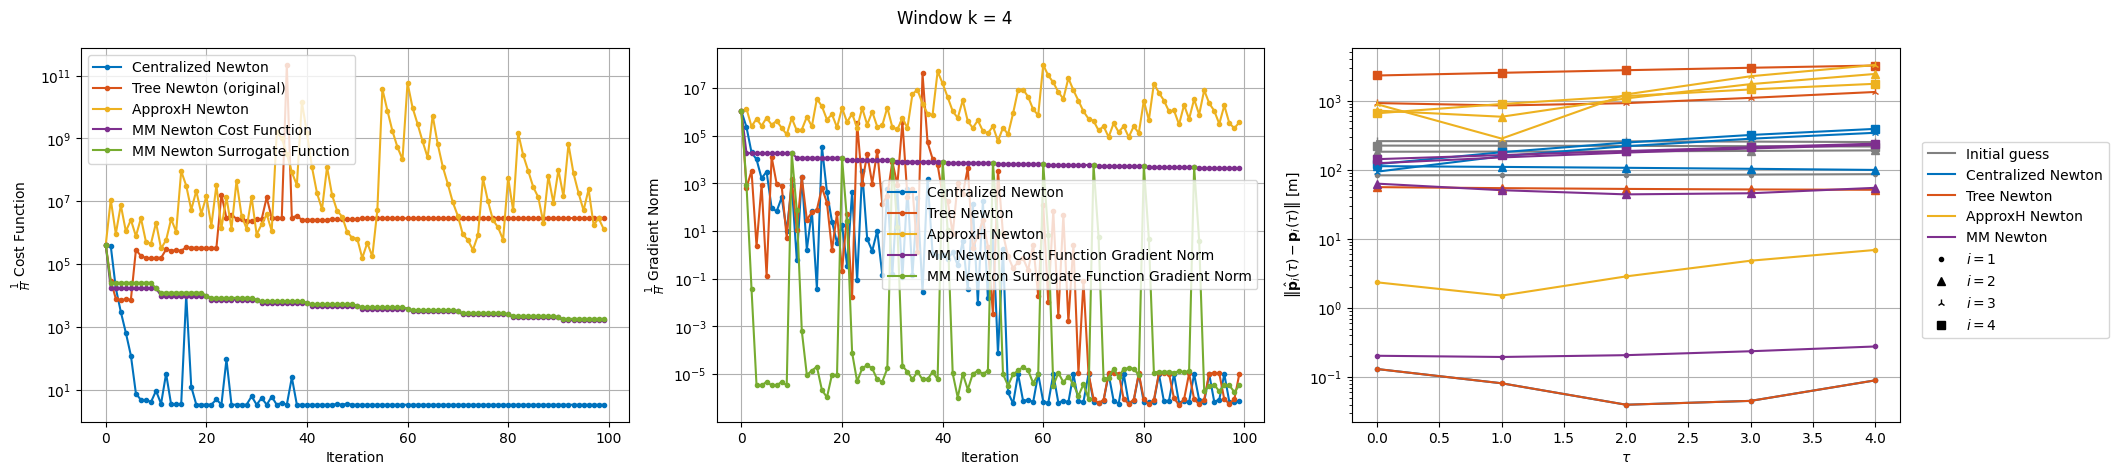


Windows:   0%|          | 1/391 [00:20<2:14:47, 20.74s/it]

-------- Centralized Newton ---------------- Tree Newton ---------------- ApproxH Newton --------


Before applying the algorithm
Cost function: 2820476.988743707
Gradient norm: 585744.5996850312
Global relative error: 1101.1725224802808
Position relative errors: 1.5067721727348273 m, 583.284744989552 m, 281.564941731097 m, 890.292155191883 m

Before applying the algorithm
Cost function: 2067158.1226762782
Gradient norm: 373.23193038865037
Global relative error: 2659.3487787661875
Position relative errors: 0.08118124060744833 m, 54.024133295545084 m, 848.101611279332 m, 2519.8966584732484 m

Before applying the algorithm
L_norm = 5.710995140303222
Grad_L_norm = 582.1602708971229

Iteration 1
Cost function: 643795.3299418685 (-77.17%)
Gradient norm: 172423.0480155724 (-70.56%)
Global relative error: 1557.659920140257 (41.45%)
Position relative errors: 6.621366637089236 m, 724.5714524569842 m, 1103.0883009738682 m, 827.1369695348271 m

Iteration 1
Cost function: 2090759.9511568497 (1.14%

/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=3.27137e-18): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 50
L_norm = 1.7055175136779088
Grad_L_norm = 0.17318274462091598

Iteration 50
Cost function: 353507.6021433322 (96.81%)
Gradient norm: 61057.45670979245 (-48.84%)
Global relative error: 3815.3326396693933 (8.43%)
Position relative errors: 7.593836135979318 m, 1982.9156511171047 m, 2248.8389574007324 m, 2359.4883199168075 m

Iteration 51
Cost function: 2139357.0423679375 (-0.01%)
Gradient norm: 0.034627383785487666 (496843.58%)
Global relative error: 3099.776481151788 (0.01%)
Position relative errors: 0.15257961145730875 m, 31.001610265715602 m, 1813.8985540041308 m, 2513.4364026217363 m

Iteration 51
L_norm = 1.8371355115260908
Grad_L_norm = 124.68216444972842

Iteration 51
Cost function: 491515.6859383622 (39.04%)
Gradient norm: 231969.1173205938 (279.92%)
Global relative error: 3474.177487719841 (-8.94%)
Position relative errors: 1.15204882148473 m, 1949.4470771683186 m, 2180.197241376811 m, 1875.1103688399828 m

Iteration 52
Cost function: 2139356.7017611726 (-0.00%)
Grad

/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=1.2649e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 52
L_norm = 1.7048536174596385
Grad_L_norm = 0.0071241320907053625

Iteration 52
Cost function: 2749811.313433458 (459.46%)
Gradient norm: 79664.6427883995 (-65.66%)
Global relative error: 4529.852581677639 (30.39%)
Position relative errors: 24.88606888383285 m, 3331.5645355767847 m, 2352.3777338734794 m, 1971.1368108913443 m

Iteration 53
Cost function: 2139354.0550775863 (-0.00%)
Gradient norm: 7.3736433626140374e-06 (17.92%)
Global relative error: 3099.7808514258345 (0.00%)
Position relative errors: 0.15257961145730875 m, 31.001610137061526 m, 1813.906022206778 m, 2513.436402622854 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=2.21411e-17): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 53
L_norm = 73.32653588194314
Grad_L_norm = 2898.4722638400785

Iteration 53
Cost function: 4848291.607542331 (76.31%)
Gradient norm: 506568.1130040478 (535.88%)
Global relative error: 6733.627161396205 (48.65%)
Position relative errors: 7.167810765232215 m, 2224.054967821923 m, 3250.9382435423936 m, 5461.359699126234 m

Iteration 54
Cost function: 2139354.054932311 (-0.00%)
Gradient norm: 4.263139192219165e-06 (-42.18%)
Global relative error: 3099.7808516635996 (0.00%)
Position relative errors: 0.15257961145730875 m, 31.001610098284388 m, 1813.9060226133151 m, 2513.436402623163 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=3.85168e-20): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 54
L_norm = 1.7041739807558105
Grad_L_norm = 3.2900309471136353

Iteration 54
Cost function: 967780.3889180187 (-80.04%)
Gradient norm: 221482.4965707138 (-56.28%)
Global relative error: 5718.482600455021 (-15.08%)
Position relative errors: 19.176288949383693 m, 3548.4083207728386 m, 3307.5024224737613 m, 3028.154083515264 m

Iteration 55
Cost function: 2139354.054894935 (-0.00%)
Gradient norm: 6.586251941549065e-06 (54.49%)
Global relative error: 3099.780851312925 (-0.00%)
Position relative errors: 0.15257961145730875 m, 31.001610036637803 m, 1813.9060220055544 m, 2513.4364026300623 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=2.11644e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 55
L_norm = 1.703135605214746
Grad_L_norm = 0.5706669286576921

Iteration 55
Cost function: 3538679.23837211 (265.65%)
Gradient norm: 413213.32072239264 (86.57%)
Global relative error: 6750.417480492724 (18.05%)
Position relative errors: 31.327652688445216 m, 4545.043382064367 m, 3889.531698722444 m, 3127.3371339301843 m

Iteration 56
Cost function: 2139354.0545720467 (-0.00%)
Gradient norm: 4.276455349016848e-06 (-35.07%)
Global relative error: 3099.780851786383 (0.00%)
Position relative errors: 0.15257961145730875 m, 31.00161020652963 m, 1813.9060228351348 m, 2513.4364026131702 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=7.47634e-20): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 56
L_norm = 1.7031286429178263
Grad_L_norm = 0.49607574936239257

Iteration 56
Cost function: 672684.926532064 (-80.99%)
Gradient norm: 174293.073724358 (-57.82%)
Global relative error: 5461.608540237444 (-19.09%)
Position relative errors: 20.545908366098487 m, 2902.7523275866256 m, 3301.324212794298 m, 3240.9465326639997 m

Iteration 57
Cost function: 2139354.0551653085 (0.00%)
Gradient norm: 5.075387209565999e-06 (18.68%)
Global relative error: 3099.78085072194 (-0.00%)
Position relative errors: 0.15257961145730875 m, 31.0016100901604 m, 1813.906020999009 m, 2513.4364026269745 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=4.4166e-20): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 57
L_norm = 1.7031223711190442
Grad_L_norm = 0.273861189432119

Iteration 57
Cost function: 12936966.13270938 (1823.18%)
Gradient norm: 1146791.8793514878 (557.97%)
Global relative error: 4208.371908282423 (-22.95%)
Position relative errors: 29.71120946772431 m, 2188.5743782135896 m, 2668.3393697992847 m, 2408.058097175857 m

Iteration 58
Cost function: 2139354.0553308837 (0.00%)
Gradient norm: 6.363900537185195e-06 (25.39%)
Global relative error: 3099.78085074982 (0.00%)
Position relative errors: 0.15257961145730875 m, 31.00160996226999 m, 1813.906021058774 m, 2513.4364026198027 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=1.54149e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 58
L_norm = 1.7031192816160168
Grad_L_norm = 0.7694003667025738

Iteration 58
Cost function: 69969764.43928793 (440.85%)
Gradient norm: 3666998.5936011244 (219.76%)
Global relative error: 3803.0895534152432 (-9.63%)
Iteration 59
Cost function: 2139354.0538498024 (-0.00%)
Gradient norm: 5.142651081595662e-06 (-19.19%)
Global relative error: 3099.7808521698726 (0.00%)Position relative errors: 44.84116513769634 m, 3265.0248642107695 m, 1420.9670283403368 m, 1332.5364719326767 m


Position relative errors: 0.15257961145730875 m, 31.001610215677257 m, 1813.9060234765714 m, 2513.4364026230896 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=6.95026e-20): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 59
L_norm = 1.703111861114819
Grad_L_norm = 0.09137620172267985

Iteration 59
Cost function: 255527208.97273487 (265.20%)
Gradient norm: 5433037.433908715 (48.16%)
Global relative error: 16082.384678327157 (322.88%)
Iteration 60
Cost function: 2139354.055175119 (0.00%)
Gradient norm: 6.216959543022894e-06 (20.89%)
Global relative error: 3099.78085129403 (-0.00%)
Position relative errors: 75.67122906739978 m, 1002.8080339780743 m, 15091.185068385914 m, 5466.081969969588 m
Position relative errors: 0.15257961145730875 m, 31.001610243722777 m, 1813.9060219856433 m, 2513.436402618574 m




/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=1.89125e-20): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 60
L_norm = 1.7032369992194547
Grad_L_norm = 4.04260166479314

Iteration 60
Cost function: 40556970.251912914 (-84.13%)
Gradient norm: 1227831.2563101149 (-77.40%)
Global relative error: 10350.030527345947 (-35.64%)
Iteration 61
Cost function: 2139354.0538018546 (-0.00%)
Gradient norm: 4.9792873493957055e-06 (-19.91%)
Global relative error: 3099.7808517867857 (0.00%)Position relative errors: 50.30355173404984 m, 7943.895361161076 m, 2754.4207589007515 m, 6035.391474468003 m


Position relative errors: 0.15257961145730875 m, 31.001610271660848 m, 1813.9060228102708 m, 2513.436402630814 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=2.01323e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 61
L_norm = 1.7030972151918449
Grad_L_norm = 0.0020677731153897045

Iteration 61
Cost function: 9256111.894317172 (-77.18%)
Gradient norm: 497054.6837275854 (-59.52%)
Global relative error: 8152.663087224353 (-21.23%)Iteration 62
Cost function: 2139354.054505206 (0.00%)
Gradient norm: 4.382495519118751e-06 (-11.99%)
Global relative error: 3099.7808509021534 (-0.00%)

Position relative errors: 63.896966592968916 m, 4241.503880501145 m, 5409.1106235950065 m, 4383.2359361097315 m
Position relative errors: 0.15257961145730875 m, 31.001610038043747 m, 1813.906021321585 m, 2513.436402617074 m




/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=2.96063e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 62
L_norm = 1.7227370348300088
Grad_L_norm = 47.99520335543821

Iteration 62
Cost function: 96749568.47889505 (945.25%)
Gradient norm: 3680024.463136697 (640.37%)
Global relative error: 5379.6561603530945 (-34.01%)Iteration 63
Cost function: 2139354.0547489575 (0.00%)
Gradient norm: 6.825038871281851e-06 (55.73%)
Global relative error: 3099.7808503737538 (-0.00%)

Position relative errors: 39.423748732022474 m, 3252.084041535105 m, 4101.86497212516 m, 1239.3476221040219 m
Position relative errors: 0.15257961145730875 m, 31.001610169822357 m, 1813.9060204012615 m, 2513.4364026279777 m




/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=4.00096e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 63
L_norm = 1.7030739325809467
Grad_L_norm = 0.0009932847836654744

Iteration 64
Cost function: 2139354.053692288 (-0.00%)
Gradient norm: 4.399395926287059e-06 (-35.54%)
Global relative error: 3099.7808520628996 (0.00%)Iteration 63
Cost function: 6698901.636529561 (-93.08%)
Gradient norm: 930344.6019790499 (-74.72%)
Global relative error: 3033.641394437967 (-43.61%)

Position relative errors: 0.15257961145730875 m, 31.001610241252354 m, 1813.9060232972192 m, 2513.4364026202857 m
Position relative errors: 20.721323209013477 m, 1502.4234486677635 m, 1789.0001607317322 m, 1934.7870823068017 m




/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=2.89173e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 64
L_norm = 1.7030746554503828
Grad_L_norm = 0.3223545061126799

Iteration 65
Cost function: 2139354.0541785695 (0.00%)
Gradient norm: 5.066861901012202e-06 (15.17%)
Global relative error: 3099.7808512616807 (-0.00%)Iteration 64
Cost function: 14603813.470524684 (118.00%)
Gradient norm: 319816.3220114865 (-65.62%)
Global relative error: 8582.597193712998 (182.91%)

Position relative errors: 0.15257961145730875 m, 31.001610220897422 m, 1813.906021922218 m, 2513.4364026247417 m
Position relative errors: 36.639934954841344 m, 1312.7182862944323 m, 4481.4538525592725 m, 7200.727953065556 m




/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=6.88437e-20): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 65
L_norm = 1.7030737702630343
Grad_L_norm = 2.5249759719851943e-06

Iteration 66
Cost function: 2139354.0541359787 (-0.00%)
Gradient norm: 6.299621613828936e-06 (24.33%)
Global relative error: 3099.7808515496376 (0.00%)Iteration 65
Cost function: 4813831.718277522 (-67.04%)
Gradient norm: 400424.31864662684 (25.20%)
Global relative error: 6619.087765743219 (-22.88%)

Position relative errors: 0.15257961145730875 m, 31.001610139648722 m, 1813.9060224256934 m, 2513.4364026175176 m
Position relative errors: 26.721777787885085 m, 4232.036584495805 m, 4030.651615300821 m, 3106.914375152221 m




/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=1.76694e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 66
L_norm = 1.7030737699566767
Grad_L_norm = 0.00035141574570075705

Iteration 67
Cost function: 2139354.0541510046 (0.00%)
Gradient norm: 5.074814032812502e-06 (-19.44%)
Global relative error: 3099.7808514672565 (-0.00%)Iteration 66
Cost function: 28727695.27535394 (496.77%)
Gradient norm: 1708961.25548369 (326.79%)
Global relative error: 6063.247207007887 (-8.40%)

Position relative errors: 0.15257961145730875 m, 31.001610371746825 m, 1813.9060222712617 m, 2513.43640262451 m
Position relative errors: 38.81965047135827 m, 3583.4916402692966 m, 3800.921994319718 m, 3077.035902795439 m




/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=4.8063e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 67
L_norm = 1.7030737703528203
Grad_L_norm = 6.821443362009636e-07

Iteration 68
Cost function: 2139354.0543335797 (0.00%)
Gradient norm: 6.2887201285897685e-06 (23.92%)
Global relative error: 3099.780851232762 (-0.00%)Iteration 67
Cost function: 5368865.190542951 (-81.31%)
Gradient norm: 502060.67597350426 (-70.62%)
Global relative error: 4886.778385732634 (-19.40%)

Position relative errors: 0.15257961145730875 m, 31.001610053755822 m, 1813.9060218821044 m, 2513.436402620088 m
Position relative errors: 25.46392110737641 m, 2681.1189293901843 m, 2787.953906657117 m, 2986.1380479424724 m




/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=3.03351e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 68
L_norm = 1.7030737700738996
Grad_L_norm = 8.867878301693968e-07

Iteration 69
Cost function: 2139354.0541986693 (-0.00%)
Gradient norm: 4.981764895142149e-06 (-20.78%)
Global relative error: 3099.7808513252685 (0.00%)Iteration 68
Cost function: 691993017.2692475 (12789.00%)
Gradient norm: 9570859.031917594 (1806.32%)
Global relative error: 13960.750185101244 (185.68%)

Position relative errors: 0.15257961145730875 m, 31.00161023854395 m, 1813.9060220280173 m, 2513.4364026265907 m
Position relative errors: 83.31215965005407 m, 3930.887178689143 m, 13156.766900905084 m, 2507.4205405773832 m




/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=1.65154e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 69
L_norm = 1.7030737701709966
Grad_L_norm = 6.730542574309829e-07

Iteration 70
Cost function: 2139354.054170318 (-0.00%)
Gradient norm: 4.264472163798779e-06 (-14.40%)
Global relative error: 3099.780851549342 (0.00%)
Iteration 69
Cost function: 115969646.20949706 (-83.24%)
Gradient norm: 3102729.1337668216 (-67.58%)
Global relative error: 8161.419212814095 (-41.54%)Position relative errors: 0.15257961145730875 m, 31.001610076915398 m, 1813.9060224204763 m, 2513.436402621692 m


Position relative errors: 81.44357355528683 m, 4834.367068044429 m, 2597.1172246826295 m, 6038.906656515849 m


/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=7.24839e-20): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)



Iteration 70
L_norm = 1.7030737704280294
Grad_L_norm = 1.0018266285862992e-05

Iteration 71
Cost function: 2139354.0547187543 (0.00%)
Gradient norm: 6.642670022296745e-06 (55.77%)
Global relative error: 3099.7808502542903 (-0.00%)
Iteration 70
Cost function: 32479701.940445125 (-71.99%)
Gradient norm: 1193395.3408609382 (-61.54%)
Global relative error: 8243.380202659435 (1.00%)Position relative errors: 0.15257961145730875 m, 31.001610101267147 m, 1813.9060201922687 m, 2513.4364026323206 m


Position relative errors: 77.65361478721763 m, 5038.3561895967505 m, 4426.49510767191 m, 4791.675421867087 m


/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=7.24631e-20): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)



Iteration 71
L_norm = 1.7030737702239773
Grad_L_norm = 5.488796213432748e-07

Iteration 72
Cost function: 2139354.054133928 (-0.00%)
Gradient norm: 4.177694294814012e-06 (-37.11%)
Global relative error: 3099.7808517289222 (0.00%)Iteration 71
Cost function: 11112397.00678548 (-65.79%)
Gradient norm: 640408.2867076346 (-46.34%)
Global relative error: 6664.240839612174 (-19.16%)

Position relative errors: 0.15257961145730875 m, 31.001610293432343 m, 1813.9060227276873 m, 2513.4364026187814 m
Position relative errors: 48.25518186218229 m, 3647.0094810578435 m, 4008.13194454138 m, 3878.1241377997617 m




/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=2.5315e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 72
L_norm = 1.7030737700365723
Grad_L_norm = 6.493714445067912e-07

Iteration 73
Cost function: 2139354.0543300714 (0.00%)
Gradient norm: 5.076422641381844e-06 (21.51%)
Global relative error: 3099.780851191864 (-0.00%)
Iteration 72
Cost function: 194727238.87660956 (1652.34%)
Gradient norm: 4359569.00338216 (580.75%)
Global relative error: 10839.286376518763 (62.65%)Position relative errors: 0.15257961145730875 m, 31.00161025467281 m, 1813.9060217993688 m, 2513.43640262688 m


Position relative errors: 42.08178510476176 m, 3417.293109066012 m, 6468.725903202323 m, 7996.902144244345 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=1.89476e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 73
L_norm = 1.7030737703057337
Grad_L_norm = 9.011874564036057e-07

Iteration 73
Cost function: 21425432.829676066 (-89.00%)
Gradient norm: 927636.1934882824 (-78.72%)
Global relative error: 3701.901162776241 (-65.85%)Iteration 74
Cost function: 2139354.0543937786 (0.00%)
Gradient norm: 6.3222751600941775e-06 (24.54%)
Global relative error: 3099.780851195062 (0.00%)

Position relative errors: 35.71450555986978 m, 1366.7749105862924 m, 3169.2181740561496 m, 1336.6426529452126 m
Position relative errors: 0.15257961145730875 m, 31.00161004372375 m, 1813.906021823183 m, 2513.43640261624 m




/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=2.34184e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 74
L_norm = 1.703073769994629
Grad_L_norm = 7.767786878397087e-07

Iteration 74
Cost function: 9618351.134890992 (-55.11%)
Gradient norm: 539338.8912789165 (-41.86%)
Global relative error: 5882.5866124645045 (58.91%)Iteration 75
Cost function: 2139354.053622363 (-0.00%)
Gradient norm: 5.062150124813756e-06 (-19.93%)
Global relative error: 3099.780852224638 (0.00%)

Position relative errors: 42.291283426529056 m, 5003.895556639358 m, 1617.7633522673116 m, 2635.448659489608 m
Position relative errors: 0.15257961145730875 m, 31.00161030620766 m, 1813.9060235630059 m, 2513.436402627135 m




/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=2.02375e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 75
L_norm = 1.7030737703375898
Grad_L_norm = 7.027659416452635e-07

Iteration 75
Cost function: 1205952.5253772081 (-87.46%)
Gradient norm: 140786.28570259392 (-73.90%)
Global relative error: 5361.782621182365 (-8.85%)Iteration 76
Cost function: 2139354.0543437605 (0.00%)
Gradient norm: 6.217447735622777e-06 (22.82%)
Global relative error: 3099.7808513075024 (-0.00%)

Position relative errors: 9.577648026321324 m, 2045.3519695050768 m, 3803.412014394016 m, 3177.8209454248326 m
Position relative errors: 0.15257961145730875 m, 31.00161013554344 m, 1813.9060220091822 m, 2513.436402619542 m




/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=1.39068e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 76
L_norm = 1.703073770118041
Grad_L_norm = 9.591787389439566e-07

Iteration 77
Cost function: 2139354.0537915225 (-0.00%)
Gradient norm: 5.005908963722719e-06 (-19.49%)
Global relative error: 3099.780851989584 (0.00%)Iteration 76
Cost function: 2443026.4076497084 (102.58%)
Gradient norm: 561143.9091852969 (298.58%)
Global relative error: 4653.765533985598 (-13.20%)

Position relative errors: 0.15257961145730875 m, 31.001610381093688 m, 1813.9060231638173 m, 2513.4364026244166 m
Position relative errors: 15.156110044758197 m, 2537.672321664957 m, 2819.4641631759755 m, 2695.81056757457 m




/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=2.0301e-20): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 77
L_norm = 1.7030737705272858
Grad_L_norm = 9.891774027317681e-06

Iteration 78
Cost function: 2139354.055535676 (0.00%)
Gradient norm: 4.259082990926604e-06 (-14.92%)
Global relative error: 3099.7808512312727 (-0.00%)Iteration 77
Cost function: 570898196.2586186 (23268.48%)
Gradient norm: 3600479.778472542 (541.63%)
Global relative error: 33923.651624576516 (628.95%)

Position relative errors: 0.15257961145730875 m, 31.001610166475032 m, 1813.9060218802451 m, 2513.4364026181925 m
Position relative errors: 206.2280434471481 m, 4611.803663683505 m, 33523.73550330206 m, 2371.8775685178866 m




/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=1.6865e-20): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 78
L_norm = 1.7030737701056438
Grad_L_norm = 6.7689079430274e-07

Iteration 79
Cost function: 2139354.054864513 (-0.00%)
Gradient norm: 6.776992581958307e-06 (59.12%)
Global relative error: 3099.780852016474 (0.00%)
Iteration 78
Cost function: 104160802.98336393 (-81.75%)
Gradient norm: 738182.7221786538 (-79.50%)
Global relative error: 19720.031448584425 (-41.87%)Position relative errors: 0.15257961145730875 m, 31.00161016651001 m, 1813.906023214724 m, 2513.436402623477 m


Position relative errors: 158.10370252357933 m, 11547.675804588765 m, 2257.0972566449614 m, 15823.978359209044 m


/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=2.75858e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)



Iteration 79
L_norm = 1.7030737703203873
Grad_L_norm = 5.346507844755731e-07

Iteration 80
Cost function: 2139354.0549643463 (0.00%)
Gradient norm: 4.3254315754227465e-06 (-36.17%)
Global relative error: 3099.7808522612327 (0.00%)
Iteration 79
Cost function: 23477555.0776387 (-77.46%)
Gradient norm: 333949.2748342396 (-54.76%)
Global relative error: 12210.833851275627 (-38.08%)Position relative errors: 0.15257961145730875 m, 31.001610142659654 m, 1813.906023639434 m, 2513.4364026191156 m


Position relative errors: 171.31101472081693 m, 6298.942327221858 m, 9006.893274653992 m, 5316.804463480161 m


/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=1.49107e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)



Iteration 80
L_norm = 1.7030737701344965
Grad_L_norm = 6.90035688993407e-07

Iteration 81
Cost function: 2139354.055402373 (0.00%)
Gradient norm: 4.9787543475117106e-06 (15.10%)
Global relative error: 3099.78085152153 (-0.00%)
Iteration 80
Cost function: 223402273.12778893 (851.56%)
Gradient norm: 5636187.8662463445 (1587.74%)
Global relative error: 11727.924702960612 (-3.95%)Position relative errors: 0.15257961145730875 m, 31.001610176409017 m, 1813.9060223664917 m, 2513.436402625115 m


Position relative errors: 144.7336860068843 m, 4933.598113830247 m, 9687.086146355638 m, 4395.42471857093 m


/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=1.41885e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)



Iteration 81
L_norm = 1.7030737702468872
Grad_L_norm = 5.506694989775161e-07

Iteration 82
Cost function: 2139354.055490638 (0.00%)
Gradient norm: 6.281548252534341e-06 (26.17%)
Global relative error: 3099.780851574766 (0.00%)
Position relative errors: 0.15257961145730875 m, 31.00161006911064 m, 1813.9060224708542 m, 2513.436402616776 m
Iteration 81
Cost function: 275647219.61579883 (23.39%)
Gradient norm: 2481563.9486075924 (-55.97%)
Global relative error: 26519.8351303839 (126.13%)



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=1.11479e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Position relative errors: 255.9087885126261 m, 9450.934491814221 m, 3523.1216921832797 m, 24524.90013404067 m

Iteration 82
L_norm = 1.703073770157765
Grad_L_norm = 6.632765261050423e-07

Iteration 83
Cost function: 2139354.054895905 (-0.00%)
Gradient norm: 5.059274617685029e-06 (-19.46%)
Global relative error: 3099.7808524683055 (0.00%)
Position relative errors: 0.15257961145730875 m, 31.001610318589027 m, 1813.9060239856346 m, 2513.436402622473 m
Iteration 82
Cost function: 51524328.88250357 (-81.31%)
Gradient norm: 987580.5099289324 (-60.20%)
Global relative error: 16052.274040213286 (-39.47%)



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=1.99031e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Position relative errors: 191.43890737576254 m, 9110.62046890541 m, 12263.024394421003 m, 4923.621343920388 m

Iteration 83
L_norm = 1.7030737703242675
Grad_L_norm = 6.399049075129037e-07

Iteration 84
Cost function: 2139354.055325714 (0.00%)
Gradient norm: 6.246954348609561e-06 (23.48%)
Global relative error: 3099.7808518230927 (-0.00%)
Iteration 83
Cost function: 17429739.49376969 (-66.17%)
Gradient norm: 476349.9809711132 (-51.77%)
Global relative error: 10652.821675756322 (-33.64%)Position relative errors: 0.15257961145730875 m, 31.001610167414864 m, 1813.9060228900173 m, 2513.4364026193116 m


Position relative errors: 142.78136650612637 m, 6044.449009128452 m, 5722.862031735998 m, 6645.969312794305 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=8.03031e-20): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 84
L_norm = 1.703073770310975
Grad_L_norm = 9.939019883771513e-06

Iteration 85
Cost function: 2139354.0552381463 (-0.00%)
Gradient norm: 5.06618691010248e-06 (-18.90%)
Global relative error: 3099.780851889944 (0.00%)Iteration 84
Cost function: 5913190.029879015 (-66.07%)
Gradient norm: 251554.75553336643 (-47.19%)
Global relative error: 7138.735278020534 (-32.99%)

Position relative errors: 0.15257961145730875 m, 31.00161027160633 m, 1813.9060229986412 m, 2513.43640262208 m
Position relative errors: 83.80562603323553 m, 3897.561090640943 m, 4260.272355865939 m, 4196.451207388593 m




/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=6.78894e-20): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 85
L_norm = 1.703073770220069
Grad_L_norm = 4.835250294913196e-07

Iteration 86
Cost function: 2139354.055428648 (0.00%)
Gradient norm: 4.393998684322741e-06 (-13.27%)
Global relative error: 3099.780851548246 (-0.00%)Iteration 85
Cost function: 527141301.279214 (8814.67%)
Gradient norm: 9010355.936500048 (3481.87%)
Global relative error: 5890.51694669312 (-17.49%)

Position relative errors: 0.15257961145730875 m, 31.001610155568464 m, 1813.9060224193884 m, 2513.436402620145 m
Position relative errors: 39.67419103172684 m, 4897.524208200173 m, 2029.6716609871185 m, 2564.0643083858954 m




/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=3.8921e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 86
L_norm = 1.7030737701119925
Grad_L_norm = 6.753595410327847e-07

Iteration 86
Cost function: 78617762.31613521 (-85.09%)
Gradient norm: 3033142.8644636096 (-66.34%)
Global relative error: 3887.8935057146437 (-34.00%)Iteration 87
Cost function: 2139354.055033141 (-0.00%)
Gradient norm: 6.690116741636674e-06 (52.26%)
Global relative error: 3099.780852166347 (0.00%)

Position relative errors: 20.5049274126535 m, 1828.959325449523 m, 2538.031982491066 m, 2307.122317360871 m
Position relative errors: 0.15257961145730875 m, 31.00161012351098 m, 1813.9060234657165 m, 2513.436402627701 m




/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=6.09916e-20): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 87
L_norm = 1.7030737701793988
Grad_L_norm = 7.228978078151626e-07

Iteration 87
Cost function: 20767831.392618634 (-73.58%)
Gradient norm: 1204762.2405097 (-60.28%)
Global relative error: 3665.8015266103766 (-5.71%)Iteration 88
Cost function: 2139354.054706007 (-0.00%)
Gradient norm: 4.248446762565974e-06 (-36.50%)
Global relative error: 3099.780852586443 (0.00%)

Position relative errors: 21.83241112955321 m, 1813.2693865867666 m, 2226.678290751253 m, 2277.8922662163122 m
Position relative errors: 0.15257961145730875 m, 31.001610224255714 m, 1813.9060241927025 m, 2513.4364026198937 m




/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=3.37701e-20): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 88
L_norm = 1.7030737702154077
Grad_L_norm = 6.262526030607594e-07

Iteration 88
Cost function: 6414653.077142971 (-69.11%)
Gradient norm: 501702.8667727319 (-58.36%)
Global relative error: 3171.0917488757127 (-13.50%)
Iteration 89
Cost function: 2139354.054780772 (0.00%)
Gradient norm: 4.9819837803274595e-06 (17.27%)
Global relative error: 3099.780852017464 (-0.00%)Position relative errors: 13.570866417045151 m, 1948.8500865106507 m, 1900.9174362666186 m, 1625.6533879946207 m


Position relative errors: 0.15257961145730875 m, 31.00161015241341 m, 1813.9060232113509 m, 2513.436402627308 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=3.69137e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 89
L_norm = 1.7030737702866918
Grad_L_norm = 6.199718849834458e-07

Iteration 89
Cost function: 115336274.27935407 (1698.01%)
Gradient norm: 4373212.294602736 (771.67%)
Global relative error: 3141.1447478932328 (-0.94%)Iteration 90
Cost function: 2139354.055470552 (0.00%)
Gradient norm: 6.2458007607523954e-06 (25.37%)
Global relative error: 3099.7808511197313 (-0.00%)

Position relative errors: 8.24336764986651 m, 1562.9054285036223 m, 1269.2813991014264 m, 2409.8758851720077 m
Position relative errors: 0.15257961145730875 m, 31.001610089606267 m, 1813.906021688203 m, 2513.4364026201756 m




/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=2.11547e-20): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 90
L_norm = 1.7030737704256738
Grad_L_norm = 9.976921864303663e-06

Iteration 91
Cost function: 2139354.0552889383 (-0.00%)
Gradient norm: 5.147433817958231e-06 (-17.59%)
Global relative error: 3099.780852362608 (0.00%)Iteration 90
Cost function: 135879177931.50748 (117711.31%)
Gradient norm: 59941987.018960595 (1270.66%)
Global relative error: 495742.64039631194 (15682.23%)

Position relative errors: 0.15257961145730875 m, 31.001610312522388 m, 1813.9060238019968 m, 2513.43640262472 m
Position relative errors: 999.2798923514506 m, 493703.2786679831 m, 44843.48743622344 m, 1392.2563978997466 m




/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=3.19375e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 91
L_norm = 1.703073770264202
Grad_L_norm = 8.391311639425433e-07

Iteration 91
Cost function: 25242827269.145267 (-81.42%)
Gradient norm: 21711976.443691652 (-63.78%)
Global relative error: 268010.3542755086 (-45.94%)Iteration 92
Cost function: 2139354.0561274854 (0.00%)
Gradient norm: 6.4054097239494175e-06 (24.44%)
Global relative error: 3099.7808512241004 (-0.00%)

Position relative errors: 2994.804010719475 m, 16957.44556566279 m, 166296.1555133815 m, 209469.2633499344 m
Position relative errors: 0.15257961145730875 m, 31.001610045047503 m, 1813.9060218664806 m, 2513.4364026207745 m




/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=5.04642e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 92
L_norm = 1.7030737701456253
Grad_L_norm = 7.182274634846351e-07

Iteration 93
Cost function: 2139354.055357843 (-0.00%)
Gradient norm: 4.9447724875985706e-06 (-22.80%)
Global relative error: 3099.780852179457 (0.00%)Iteration 92
Cost function: 5930825379.814016 (-76.50%)
Gradient norm: 8368580.735261286 (-61.46%)
Global relative error: 160226.93464861857 (-40.22%)

Position relative errors: 0.15257961145730875 m, 31.001610330228043 m, 1813.9060234908825 m, 2513.436402623156 m
Position relative errors: 2529.2996678179443 m, 126304.97387992767 m, 76205.91747129188 m, 62494.37726195701 m




/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=1.54785e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 93
L_norm = 1.7030737701567855
Grad_L_norm = 5.76932278276567e-07

Iteration 93
Cost function: 2053937413.7843292 (-65.37%)
Gradient norm: 3526634.1695908145 (-57.86%)
Global relative error: 104705.73225670411 (-34.65%)Iteration 94
Cost function: 2139354.055723939 (0.00%)
Gradient norm: 4.389672710963146e-06 (-11.23%)
Global relative error: 3099.780851648655 (-0.00%)

Position relative errors: 1706.2484595308017 m, 47766.937658427676 m, 63986.59092152861 m, 67706.91150355649 m
Position relative errors: 0.15257961145730875 m, 31.001610187372957 m, 1813.9060225860028 m, 2513.436402623337 m




/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=3.00922e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 94
L_norm = 1.703073770030268
Grad_L_norm = 6.829192652465294e-07

Iteration 95
Cost function: 2139354.0558465878 (0.00%)
Gradient norm: 6.747966098457065e-06 (53.72%)
Global relative error: 3099.780851487199 (-0.00%)Iteration 94
Cost function: 862346623.8847297 (-58.01%)
Gradient norm: 2408376.9722507824 (-31.71%)
Global relative error: 69246.12492493114 (-33.87%)

Position relative errors: 0.15257961145730875 m, 31.001610050454396 m, 1813.9060223041013 m, 2513.4364026293533 m
Position relative errors: 1122.25536547191 m, 44135.91561169174 m, 38209.97412578512 m, 37225.07292206443 m




/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=2.61173e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 95
L_norm = 1.7030737702940422
Grad_L_norm = 6.210471368503775e-07

Iteration 96
Cost function: 2139354.055259899 (-0.00%)
Gradient norm: 4.2545107635117865e-06 (-36.95%)
Global relative error: 3099.780852404858 (0.00%)Iteration 95
Cost function: 321744752.64031565 (-62.69%)
Gradient norm: 1800005.8856198636 (-25.26%)
Global relative error: 44179.27520837801 (-36.20%)

Position relative errors: 0.15257961145730875 m, 31.001610189770332 m, 1813.9060238894358 m, 2513.436402615236 m
Position relative errors: 698.787334802667 m, 26779.458242727032 m, 25171.15844413053 m, 24506.192166437657 m




/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=4.19111e-20): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 96
L_norm = 1.703073770181265
Grad_L_norm = 7.128730945278939e-07

Iteration 97
Cost function: 2139354.055792908 (0.00%)
Gradient norm: 5.080722765244211e-06 (19.42%)
Global relative error: 3099.780851799588 (-0.00%)Iteration 96
Cost function: 104297427.61961736 (-67.58%)
Gradient norm: 605035.2727049805 (-66.39%)
Global relative error: 27018.461791857557 (-38.84%)

Position relative errors: 0.15257961145730875 m, 31.0016101111319 m, 1813.9060228405885 m, 2513.436402626686 m

Position relative errors: 403.79200927789844 m, 16866.532765694803 m, 15162.160645759644 m, 14678.108950156435 m



/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=1.70927e-19): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 97
L_norm = 1.7030737704535288
Grad_L_norm = 9.942404566371607e-06

Iteration 98
Cost function: 2139354.0554981693 (-0.00%)
Gradient norm: 6.275894604469113e-06 (23.52%)
Global relative error: 3099.7808523791136 (0.00%)Iteration 97
Cost function: 497316362.3234798 (376.83%)
Gradient norm: 8644701.735177951 (1328.79%)
Global relative error: 14652.573366144195 (-45.77%)

Position relative errors: 0.15257961145730875 m, 31.001610081697415 m, 1813.9060238414688 m, 2513.4364026194344 m
Position relative errors: 238.69544219714197 m, 9545.370671735269 m, 9802.15909329222 m, 5237.289584811562 m




/home/vican/g/SpaceSim-Toolkit/test/newton_based_algorithms/tree_newton.py:465: LinAlgWarning: Ill-conditioned matrix (rcond=2.07638e-20): result may not be accurate.
  delta_x = solve(hessian_L_x, -grad_L_x)


Iteration 98
L_norm = 1.703073770028367
Grad_L_norm = 7.278320053224702e-07

STOP on Iteration 99
Cost function = 2139354.0556204207 (0.00%)
Gradient norm = 5.039099154108387e-06 (-19.71%)
Global relative error = 3099.7808520794447 (-0.00%)Iteration 98
Cost function: 57662773.49693532 (-88.41%)
Gradient norm: 2053886.4241552863 (-76.24%)
Global relative error: 10048.827743849713 (-31.42%)

Final position relative errors: 0.15257961145730875 m, 31.001610209363395 m, 1813.906023319565 m, 2513.436402624942 m
Position relative errors: 130.95534435498908 m, 5590.751018573563 m, 5264.294335187786 m, 6480.051953062527 m


STOP on Iteration 99
L_norm = 1.7030737703127055
Grad_L_norm = 5.905530286117026e-07

-------- MM Newton --------Final position relative errors: [0.15257961060938785, 1833.9251459000936, 2023.85149759985, 2080.6643109787915] m


Majorization-Minimization Iteration 1
STOP on Iteration 99
Cost function = 15564780.35422654 (-73.01%)
Gradient norm = 726817.5912730041 (-64.61%)
G

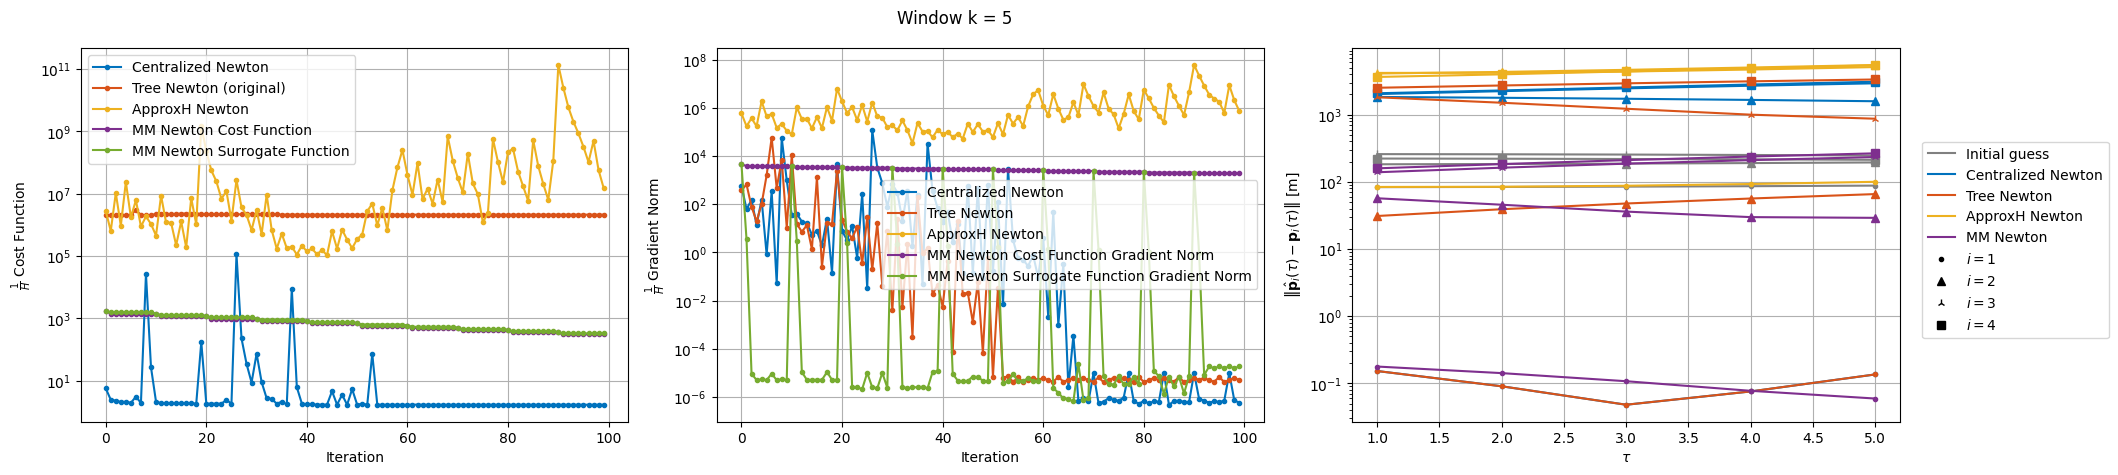


Windows:   1%|          | 2/391 [00:41<2:15:06, 20.84s/it]

-------- Centralized Newton ---------------- Tree Newton --------

-------- ApproxH Newton --------
Before applying the algorithm
L_norm = 6.940866950059903
Grad_L_norm = 956.61625447447

Before applying the algorithm
Cost function: 18528865.330949537
Gradient norm: 812953.6532703878
Global relative error: 7224.649067380308
Before applying the algorithm
Cost function: 1616869.4397703153
Gradient norm: 926.1633615528858
Global relative error: 3105.2490569791594Position relative errors: 84.37886210756682 m, 4325.102007117445 m, 4199.922578353598 m, 3980.2302212200148 m


Position relative errors: 0.09044781254573513 m, 39.0855752627007 m, 1503.7081937482471 m, 2716.5869675864183 m

Iteration 1
Cost function: 2180578.1200631224 (34.86%)
Gradient norm: 6894.606401714462 (644.43%)
Global relative error: 3267.4730666673545 (5.22%)
Position relative errors: 0.03741932194179399 m, 525.9243477538697 m, 1752.5752117455233 m, 2707.0676635765094 m

Iteration 1
Cost function: 16611605.76799168 (-10

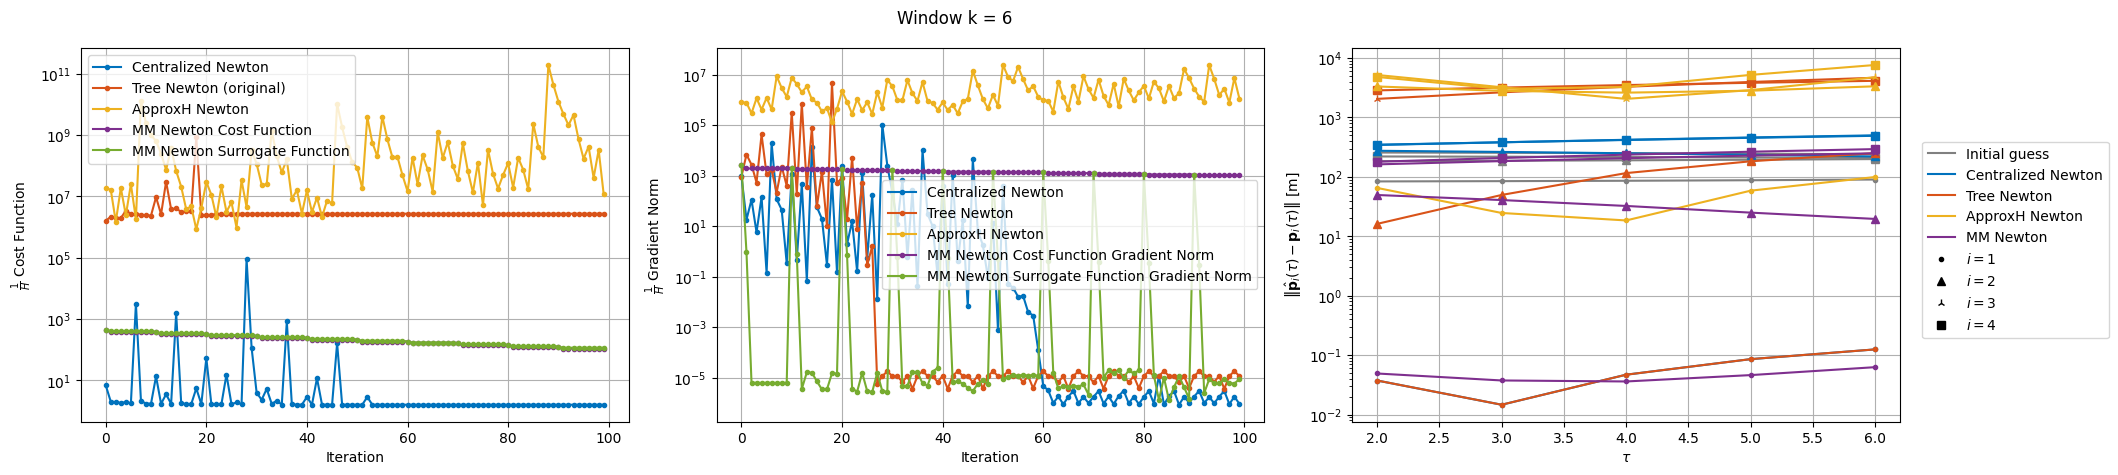


Windows:   1%|          | 3/391 [01:01<2:12:56, 20.56s/it]

-------- Centralized Newton ---------------- Tree Newton ---------------- ApproxH Newton --------


Before applying the algorithm
Cost function: 3305422.9653504062
Gradient norm: 3764.0469610675996
Global relative error: 4143.415419866886
Position relative errors: 0.014638853024458566 m, 49.66368898815748 m, 2648.7393174472268 m, 3185.818270438804 m

Before applying the algorithm
L_norm = 2.551555442253191
Grad_L_norm = 630.368862696622

Before applying the algorithm
Cost function: 24904076.04866198
Gradient norm: 1806046.2771898122
Global relative error: 5244.791197363587
Position relative errors: 24.70751673533987 m, 2807.1705136196797 m, 3226.51839817924 m, 3035.249420074999 m

Iteration 1
Cost function: 3322296.846939063 (0.51%)
Gradient norm: 2.332697622847075 (-99.94%)
Global relative error: 4119.775413072521 (-0.57%)
Position relative errors: 0.06680390045033181 m, 53.78716619515136 m, 2622.411085386457 m, 3176.8605795102276 m

Iteration 1
L_norm = 1.5983946850259414
Grad_L_norm

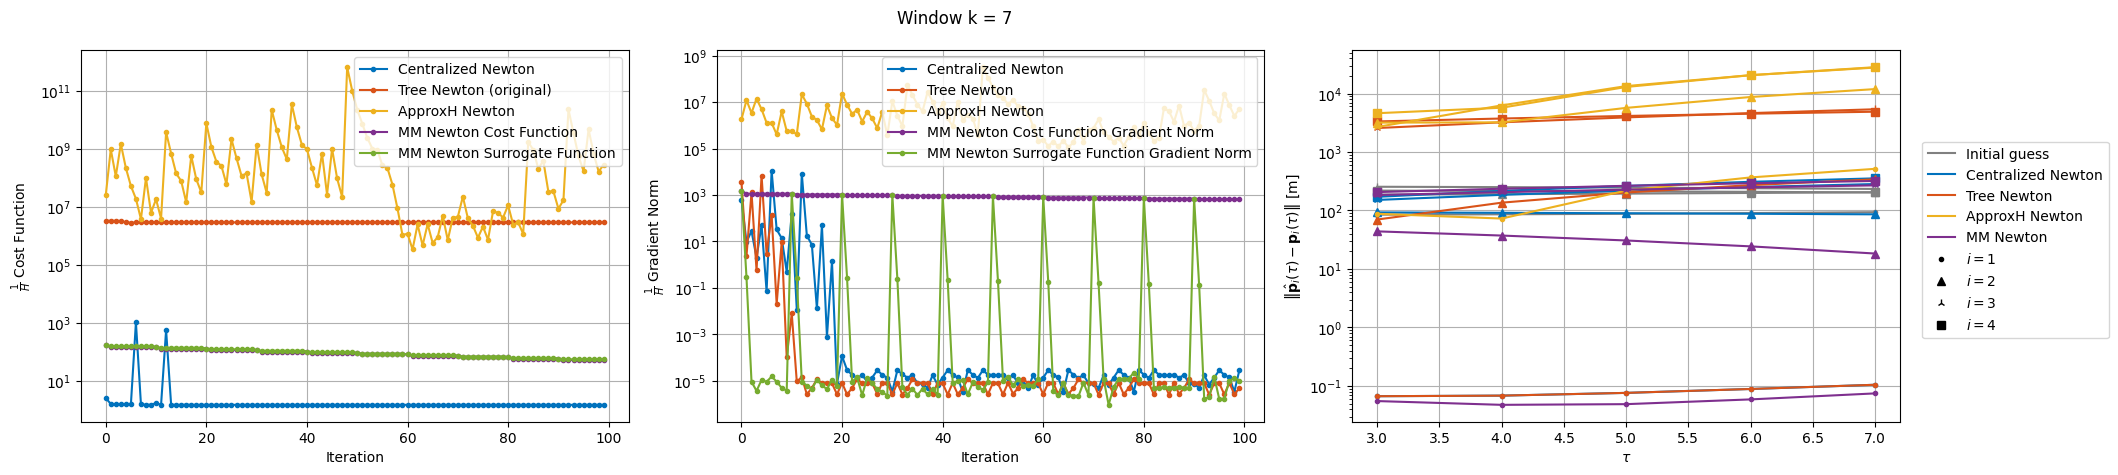


Windows:   1%|          | 4/391 [01:22<2:13:52, 20.76s/it]

-------- Centralized Newton ---------------- Tree Newton ---------------- ApproxH Newton --------


Before applying the algorithm
Cost function: 555049099.0342987
Gradient norm: 7051061.733399168
Global relative error: 9072.007438077086
Position relative errors: 72.80065457712107 m, 3212.509065046571 m, 6267.738242619943 m, 5714.54651804841 m

Before applying the algorithm
L_norm = 3.977733209448806
Grad_L_norm = 1966.914080468791

Before applying the algorithm
Cost function: 3762912.208485479
Gradient norm: 2374.8597615188914
Global relative error: 4932.353370367282
Position relative errors: 0.06837202013433684 m, 136.0333277315985 m, 3217.4578524167005 m, 3735.9573439110222 m

Iteration 1
Cost function: 138254898.07594785 (-75.09%)
Gradient norm: 4053799.7253790474 (-42.51%)
Global relative error: 9009.890525386501 (-0.68%)
Position relative errors: 70.82495907399505 m, 3085.1945203194978 m, 5271.378924785073 m, 6622.567015485345 m

Iteration 1
L_norm = 9.213593791170222
Grad_L_norm 

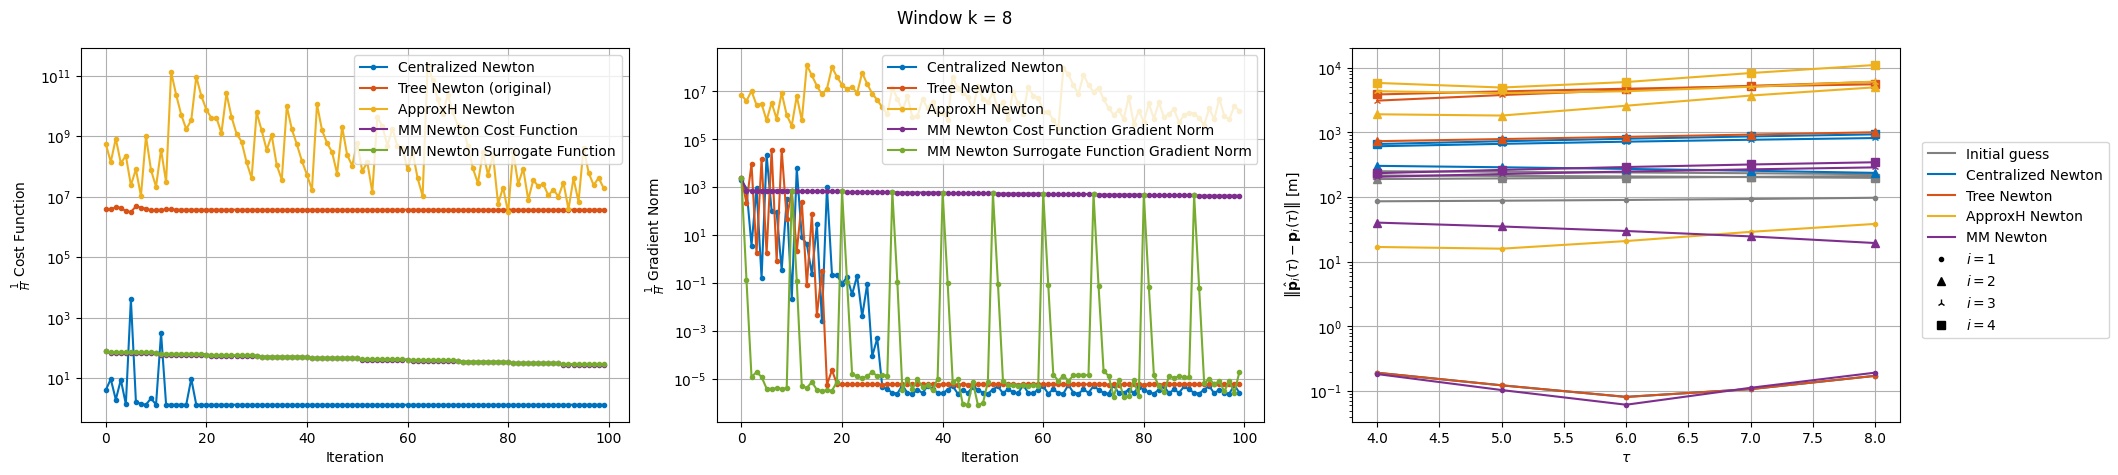


Windows:   1%|▏         | 5/391 [01:43<2:13:38, 20.77s/it]

-------- Centralized Newton ---------------- Tree Newton ---------------- ApproxH Newton --------


Before applying the algorithm
Cost function: 42368993.69376023
Gradient norm: 2508684.117636017
Global relative error: 6646.66584831441Before applying the algorithm
Cost function: 4833180.762385078
Gradient norm: 1699.463179301823
Global relative error: 5788.132806967865

Position relative errors: 0.12267584926726216 m, 789.2179293495292 m, 3783.211236897016 m, 4308.9118481313335 m
Position relative errors: 15.91937521091952 m, 1823.3095797478347 m, 4047.1964758278286 m, 4946.668242436207 m


Before applying the algorithm
L_norm = 4.8566659241243935
Grad_L_norm = 1357.204646848401

Iteration 1
Cost function: 4818570.753524578 (-0.30%)
Gradient norm: 12.16330107703374 (-99.28%)
Global relative error: 5776.294384131057 (-0.20%)
Position relative errors: 0.09649905976474847 m, 769.887999394009 m, 3789.334111923014 m, 4291.105847350186 m

Iteration 1
Cost function: 12867518.549535822 (-69.63


Process ForkProcess-127:
                                                          Process ForkProcess-128:
Traceback (most recent call last):
Traceback (most recent call last):
MC runs:   0%|          | 0/1 [01:57<?, ?it/s]  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/concurrent/futures/process.py", line 240, in _process_worker
    call_item = call_queue.get(block=True)
  File "/usr/lib/python3.10/concurrent/futures/process.py", line 240, in _process_worker
    call_item = call_queue.get(block=True)

  File "/usr/lib/python3.10/multiprocessing/queues.py", line 102, in get
    w

KeyboardInterrupt: 

  File "/usr/lib/python3.10/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
KeyboardInterrupt
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 414, in _recv_bytes
    buf = self._recv(4)
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt


In [218]:
if use_several_cpus and use_causal:
    # DISTRIBUTED OVER SEVERAL CPUs AND CAUSAL
    
    # Initialize storage arrays for state estimates
    X_est_unkkt_history = np.zeros((24, 1, K))  # Centralized Newton
    X_est_tree_newton_history = np.zeros((24, 1, K))  # Tree Newton
    X_est_approx_newton_history = np.zeros((24, 1, K))  # ApproxH Newton
    X_est_mm_history = np.zeros((24, 1, K))  # MM Newton
    
    def solve_algorithm(algorithm_name, algorithm, X_est, dt, Y, X_true, n):
        """
        Solves the estimation problem for a given algorithm.
        Returns the algorithm name, updated X_est, and cost function/gradient data for plotting.
        """
        print(f"-------- {algorithm_name} --------")
        
        if algorithm_name == "Centralized Newton":
            X_est = algorithm.solve_for_each_window(dt, X_est, Y[:, :, n - W + 1 : n + 1])
            final_errors = [
                np.linalg.norm(X_true[:3, :, n - W + 1] - X_est[:3]),
                np.linalg.norm(X_true[6:9, :, n - W + 1] - X_est[6:9]),
                np.linalg.norm(X_true[12:15, :, n - W + 1] - X_est[12:15]),
                np.linalg.norm(X_true[18:21, :, n - W + 1] - X_est[18:21])
            ]
            print(f"Final position relative errors: {final_errors} m")
        
        elif algorithm_name in ["Tree Newton", "ApproxH Newton", "MM Newton"]:
            X_est = algorithm.solve_for_each_window(dt, X_est, Y[:, :, n - W + 1 : n + 1], X_true[:, :, n - W + 1])
    
        # Collect cost function and gradient norm data
        return (
            algorithm_name,
            X_est,
            algorithm.cost_function_values.copy(),
            algorithm.grad_norm_values.copy(),
            algorithm.surrogate_function_values.copy() if hasattr(algorithm, "surrogate_function_values") else [],
            algorithm.surrogate_grad_norm_values.copy() if hasattr(algorithm, "surrogate_grad_norm_values") else []
        )
    
    # ================= MAIN EXECUTION =================
    for m in tqdm(range(M), desc="MC runs", leave=True):
        # Generate observations
        Y = np.zeros((9, 1, T))
        for t in range(T):
            Y[:, :, t] = unkkt.h(X_true[:, :, t]) + np.random.multivariate_normal(np.zeros(9), R).reshape((9, 1))
    
        # Initialize state estimates
        X_est_unkkt = X_initial + initial_dev
        X_est_tree_newton = X_initial + initial_dev
        X_est_approx_newton = X_initial + initial_dev
        X_est_mm = X_initial + initial_dev
    
        for n in tqdm(range(W - 1, K), desc="Windows", leave=False):
            with ProcessPoolExecutor(max_workers=3) as executor:
                # Run each algorithm in parallel
                future_to_algorithm = {
                    executor.submit(solve_algorithm, "Centralized Newton", unkkt, X_est_unkkt, dt, Y, X_true, n): "Centralized Newton",
                    executor.submit(solve_algorithm, "Tree Newton", tree_newton, X_est_tree_newton, dt, Y, X_true, n): "Tree Newton",
                    executor.submit(solve_algorithm, "ApproxH Newton", approxh_newton, X_est_approx_newton, dt, Y, X_true, n): "ApproxH Newton",
                    executor.submit(solve_algorithm, "MM Newton", mm_newton, X_est_mm, dt, Y, X_true, n): "MM Newton"
                }
    
                # Retrieve results in the main process
                results = {future.result()[0]: future.result()[1:] for future in future_to_algorithm}
    
            # Extract updated estimates
            X_est_unkkt, cost_unkkt, grad_unkkt, _, _ = results["Centralized Newton"]
            X_est_tree_newton, cost_tree, grad_tree, _, _ = results["Tree Newton"]
            X_est_approx_newton, cost_approx, grad_approx, _, _ = results["ApproxH Newton"]
            X_est_mm, cost_mm, grad_mm, surrogate_cost_mm, surrogate_grad_mm = results["MM Newton"]
            
            # Propagate the estimated initial conditions until the end of the finite-horizon window
            if n == W - 1:
                X_est_unkkt_history[:, :, 0] = X_est_unkkt
                X_est_tree_newton_history[:, :, 0] = X_est_tree_newton
                X_est_approx_newton_history[:, :, 0] = X_est_approx_newton
                X_est_mm_history[:, :, 0] = X_est_mm
                for tau in range(W - 1):
                    X_est_unkkt_history[:, :, tau + 1] = unkkt.dynamic_model.x_new(dt, X_est_unkkt_history[:, :, tau])
                    X_est_tree_newton_history[:, :, tau + 1] = tree_newton.dynamic_model.x_new(dt, X_est_tree_newton_history[:, :, tau])
                    X_est_approx_newton_history[:, :, tau + 1] = approxh_newton.dynamic_model.x_new(dt, X_est_approx_newton_history[:, :, tau])
                    X_est_mm_history[:, :, tau + 1] = mm_newton.dynamic_model.x_new(dt, X_est_mm_history[:, :, tau])
            else:
                X_est_unkkt_history[:, :, n] = X_est_unkkt
                X_est_tree_newton_history[:, :, n] = X_est_tree_newton
                X_est_approx_newton_history[:, :, n] = X_est_approx_newton
                X_est_mm_history[:, :, n] = X_est_mm
                for tau in range(W - 1):
                    X_est_unkkt_history[:, :, n] = unkkt.dynamic_model.x_new(dt, X_est_unkkt_history[:, :, n])
                    X_est_tree_newton_history[:, :, n] = tree_newton.dynamic_model.x_new(dt, X_est_tree_newton_history[:, :, n])
                    X_est_approx_newton_history[:, :, n] = approxh_newton.dynamic_model.x_new(dt, X_est_approx_newton_history[:, :, n])
                    X_est_mm_history[:, :, n] = mm_newton.dynamic_model.x_new(dt, X_est_mm_history[:, :, n])
                
            # Plot results **in the main process**
            fig, axs = plt.subplots(1, 3, figsize=(3 * 6.4, 4.8))
    
            # Cost function values
            axs[0].plot(cost_unkkt, '.-', label='Centralized Newton')
            axs[0].plot(cost_tree, '.-', label='Tree Newton (original)')
            axs[0].plot(cost_approx, '.-', label='ApproxH Newton')
            axs[0].plot(cost_mm, '.-', label='MM Newton Cost Function')
            axs[0].plot(surrogate_cost_mm, '.-', label='MM Newton Surrogate Function')
            axs[0].set_xlabel('Iteration')
            axs[0].set_ylabel(r'$\frac{1}{H}$ Cost Function')
            axs[0].set_yscale('log')
            axs[0].grid(True)
            axs[0].legend()
    
            # Gradient norm values
            axs[1].plot(grad_unkkt, '.-', label='Centralized Newton')
            axs[1].plot(grad_tree, '.-', label='Tree Newton')
            axs[1].plot(grad_approx, '.-', label='ApproxH Newton')
            axs[1].plot(grad_mm, '.-', label='MM Newton Cost Function Gradient Norm')
            axs[1].plot(surrogate_grad_mm, '.-', label='MM Newton Surrogate Function Gradient Norm')
            axs[1].set_xlabel('Iteration')
            axs[1].set_ylabel(r'$\frac{1}{H}$ Gradient Norm')
            axs[1].set_yscale('log')
            axs[1].grid(True)
            axs[1].legend()

            # Initialize storage for current estimates
            X_est_unkkt_current = np.zeros((24, 1, W))
            X_est_tree_newton_current = np.zeros((24, 1, W))
            X_est_approx_newton_current = np.zeros((24, 1, W))
            X_est_mm_current = np.zeros((24, 1, W))
            
            # Simulate forward propagation over the window
            X_est_unkkt_current[:, :, 0] = X_est_unkkt
            X_est_tree_newton_current[:, :, 0] = X_est_tree_newton
            X_est_approx_newton_current[:, :, 0] = X_est_approx_newton
            X_est_mm_current[:, :, 0] = X_est_mm
            
            for tau in range(W - 1):
                X_est_unkkt_current[:, :, tau + 1] = unkkt.dynamic_model.x_new(dt, X_est_unkkt_current[:, :, tau])
                X_est_tree_newton_current[:, :, tau + 1] = tree_newton.dynamic_model.x_new(dt, X_est_tree_newton_current[:, :, tau])
                X_est_approx_newton_current[:, :, tau + 1] = approxh_newton.dynamic_model.x_new(dt, X_est_approx_newton_current[:, :, tau])
                X_est_mm_current[:, :, tau + 1] = mm_newton.dynamic_model.x_new(dt, X_est_mm_current[:, :, tau])
            
            # Compute position estimation errors
            dev_chief_unkkt_current, dev_deputy1_unkkt_current, dev_deputy2_unkkt_current, dev_deputy3_unkkt_current = position_estimation_error(X_est_unkkt_current, X_true[:, :, n - W + 1 : n + 1])
            dev_chief_tree_current, dev_deputy1_tree_current, dev_deputy2_tree_current, dev_deputy3_tree_current = position_estimation_error(X_est_tree_newton_current, X_true[:, :, n - W + 1 : n + 1])
            dev_chief_approxh_current, dev_deputy1_approxh_current, dev_deputy2_approxh_current, dev_deputy3_approxh_current = position_estimation_error(X_est_approx_newton_current, X_true[:, :, n - W + 1 : n + 1])
            dev_chief_mm_current, dev_deputy1_mm_current, dev_deputy2_mm_current, dev_deputy3_mm_current = position_estimation_error(X_est_mm_current, X_true[:, :, n - W + 1 : n + 1])
            
            # Define colors for algorithms
            algorithm_colors = {
                'Initial guess': 'grey',
                'Centralized Newton': 'C0',
                'Tree Newton': 'C1',
                'ApproxH Newton': 'C2',
                'MM Newton': 'C3'
            }
            
            # Define markers for different agents (i = 1, ..., 4)
            markers = ['.', '^', '2', 's', 'P']
            
            # Plot Initial Guess deviations (use the same color for all i)
            for i, dev_initial in enumerate([dev_chief_initial, dev_deputy1_initial, dev_deputy2_initial, dev_deputy3_initial]):
                axs[2].plot(np.arange(n - W + 1, n + 1), dev_initial[n - W + 1 : n + 1], linestyle='-', color=algorithm_colors['Initial guess'], marker=markers[i])
            
            # Plot Centralized Newton deviations
            for i, dev_unkkt in enumerate([dev_chief_unkkt_current, dev_deputy1_unkkt_current, dev_deputy2_unkkt_current, dev_deputy3_unkkt_current]):
                axs[2].plot(np.arange(n - W + 1, n + 1), dev_unkkt, linestyle='-', color=algorithm_colors['Centralized Newton'], marker=markers[i])
            
            # Plot Tree Newton deviations
            for i, dev_tree in enumerate([dev_chief_tree_current, dev_deputy1_tree_current, dev_deputy2_tree_current, dev_deputy3_tree_current]):
                axs[2].plot(np.arange(n - W + 1, n + 1), dev_tree, linestyle='-', color=algorithm_colors['Tree Newton'], marker=markers[i])
            
            # Plot ApproxH Newton deviations
            for i, dev_approxh in enumerate([dev_chief_approxh_current, dev_deputy1_approxh_current, dev_deputy2_approxh_current, dev_deputy3_approxh_current]):
                axs[2].plot(np.arange(n - W + 1, n + 1), dev_approxh, linestyle='-', color=algorithm_colors['ApproxH Newton'], marker=markers[i])
            
            # Plot MM Newton deviations
            for i, dev_mm in enumerate([dev_chief_mm_current, dev_deputy1_mm_current, dev_deputy2_mm_current, dev_deputy3_mm_current]):
                axs[2].plot(np.arange(n - W + 1, n + 1), dev_mm, linestyle='-', color=algorithm_colors['MM Newton'], marker=markers[i])
            
            # Set axis labels and scale
            axs[2].set_xlabel(r'$\tau$')
            axs[2].set_ylabel(r'$\left\|\hat{\mathbf{p}}_i(\tau) - \mathbf{p}_i(\tau)\right\|$ [m]')
            axs[2].set_yscale('log')
            axs[2].grid(True)
            
            # Create legend (Colors for Algorithms, Markers for Agents)
            legend_elements = [
                Line2D([0], [0], linestyle='-', color=algorithm_colors['Initial guess'], label='Initial guess'),
                Line2D([0], [0], linestyle='-', color=algorithm_colors['Centralized Newton'], label='Centralized Newton'),
                Line2D([0], [0], linestyle='-', color=algorithm_colors['Tree Newton'], label='Tree Newton'),
                Line2D([0], [0], linestyle='-', color=algorithm_colors['ApproxH Newton'], label='ApproxH Newton'),
                Line2D([0], [0], linestyle='-', color=algorithm_colors['MM Newton'], label='MM Newton'),
                Line2D([0], [0], linestyle='', marker='.', color='black', label='$i = 1$'),
                Line2D([0], [0], linestyle='', marker='^', color='black', label='$i = 2$'),
                Line2D([0], [0], linestyle='', marker='2', color='black', label='$i = 3$'),
                Line2D([0], [0], linestyle='', marker='s', color='black', label='$i = 4$')
            ]
            fig.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
    
            fig.suptitle(f'Window k = {n}')
            plt.tight_layout() 
            plt.show()
    
            # Update state estimates
            X_est_unkkt = unkkt.dynamic_model.x_new(dt, X_est_unkkt)
            X_est_tree_newton = tree_newton.dynamic_model.x_new(dt, X_est_tree_newton)
            X_est_approx_newton = approxh_newton.dynamic_model.x_new(dt, X_est_approx_newton)
            X_est_mm = mm_newton.dynamic_model.x_new(dt, X_est_mm)

In [ ]:
# Extract deviations for Chief and Deputies
dev_chief_unkkt, dev_deputy1_unkkt, dev_deputy2_unkkt, dev_deputy3_unkkt = position_estimation_error(X_est_unkkt_history, X_true)
dev_chief_tree, dev_deputy1_tree, dev_deputy2_tree, dev_deputy3_tree = position_estimation_error(X_est_tree_newton_history, X_true)
dev_chief_approx, dev_deputy1_approx, dev_deputy2_approx, dev_deputy3_approx = position_estimation_error(X_est_approx_newton_history, X_true)
dev_chief_mm, dev_deputy1_mm, dev_deputy2_mm, dev_deputy3_mm = position_estimation_error(X_est_mm_history, X_true)

# Time array
T = X_true.shape[2]

# MATLAB default color cycle
matlab_default_colors = [
    [0, 0.4470, 0.7410],  # blue
    [0.8500, 0.3250, 0.0980],  # orange
    [0.9290, 0.6940, 0.1250],  # yellow
    [0.4940, 0.1840, 0.5560],  # purple
    [0.4660, 0.6740, 0.1880],  # green
    [0.3010, 0.7450, 0.9330],  # light blue
    [0.6350, 0.0780, 0.1840],  # red
]
# Set the color cycle in Matplotlib to match MATLAB's default
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=matlab_default_colors)

time = np.arange(0, T) / dt

# Plot positions based on screen size
fig_width = 2 * 6.4  # in inchesa
fig_height = 2 * 4.8  # in inches

# Create a 2 by 2 figure
fig, axs = plt.subplots(2, 2, figsize=(fig_width, fig_height))

# Plot 1: Chief
axs[0, 0].plot(time, dev_chief_initial, ".-", color='grey', label="Initial")
axs[0, 0].plot(time, dev_chief_unkkt, ".-", color='C0', label="Centralized Newton")
axs[0, 0].plot(time, dev_chief_tree, ".-", color='C1', label="Tree Newton")
axs[0, 0].plot(time, dev_chief_approx, ".-", color='C2', label="ApproxH Newton")
axs[0, 0].plot(time, dev_chief_mm, ".-", color='C3', label="MM Newton")
axs[0, 0].grid(which="major", color="#DDDDDD", zorder=1)
axs[0, 0].grid(which="minor", color="#DDDDDD", linestyle=(0, (1, 3)), zorder=2)
axs[0, 0].grid(True, which="both")
axs[0, 0].set_yscale("log")
axs[0, 0].set_xlabel("$t$ [h]", fontsize=12)
axs[0, 0].set_ylabel(
    "$\\left\\|\\hat{\\mathbf{p}}_1(t) - \\mathbf{p}_1(t)\\right\\|$ [m]",
    fontsize=12,
)
# axs[0, 0].set_ylim([1e-2, 1e3])
axs[0, 0].tick_params(axis="both", which="both", direction="in")
axs[0, 0].legend(fontsize=12)

# Plot 2: Deputy 1
axs[0, 1].plot(time, dev_deputy1_initial, ".-", color='grey', label="Initial")
axs[0, 1].plot(time, dev_deputy1_unkkt, ".-", color='C0', label="Centralized Newton")
axs[0, 1].plot(time, dev_deputy1_tree, ".-", color='C1', label="Tree Newton")
axs[0, 1].plot(time, dev_deputy1_approx, ".-", color='C2', label="ApproxH Newton")
axs[0, 1].plot(time, dev_deputy1_mm, ".-", color='C3', label="MM Newton")
axs[0, 1].grid(which="major", color="#DDDDDD", zorder=1)
axs[0, 1].grid(which="minor", color="#DDDDDD", linestyle=(0, (1, 3)), zorder=2)
axs[0, 1].grid(True, which="both")
axs[0, 1].set_yscale("log")
axs[0, 1].set_xlabel("$t$ [h]", fontsize=12)
axs[0, 1].set_ylabel(
    "$\\left\\|\\hat{\\mathbf{p}}_2(t) - \\mathbf{p}_2(t)\\right\\|$ [m]",
    fontsize=12,
)
# axs[0, 1].set_ylim([1e-1, 1e3])
axs[0, 1].tick_params(axis="both", which="both", direction="in")
axs[0, 1].legend(fontsize=12)

# Plot 3: Deputy 2
axs[1, 0].plot(time, dev_deputy2_initial, ".-", color='grey', label="Initial")
axs[1, 0].plot(time, dev_deputy2_unkkt, ".-", color='C0', label="Centralized Newton")
axs[1, 0].plot(time, dev_deputy2_tree, ".-", color='C1', label="Tree Newton")
axs[1, 0].plot(time, dev_deputy2_approx, ".-", color='C2', label="ApproxH Newton")
axs[1, 0].plot(time, dev_deputy2_mm, ".-", color='C3', label="MM Newton")
axs[1, 0].grid(which="major", color="#DDDDDD", zorder=1)
axs[1, 0].grid(which="minor", color="#DDDDDD", linestyle=(0, (1, 3)), zorder=2)
axs[1, 0].grid(True, which="both")
axs[1, 0].set_yscale("log")
axs[1, 0].set_xlabel("$t$ [h]", fontsize=12)
axs[1, 0].set_ylabel(
    "$\\left\\|\\hat{\\mathbf{p}}_3(t) - \\mathbf{p}_3(t)\\right\\|$ [m]",
    fontsize=12,
)
# axs[1, 0].set_ylim([1e-1, 1e3])
axs[1, 0].tick_params(axis="both", which="both", direction="in")
axs[1, 0].legend(fontsize=12)

# Plot 4: Deputy 3
axs[1, 1].plot(time, dev_deputy3_initial, ".-", color='grey', label="Initial")
axs[1, 1].plot(time, dev_deputy3_unkkt, ".-", color='C0', label="Centralized Newton")
axs[1, 1].plot(time, dev_deputy3_tree, ".-", color='C1', label="Tree Newton")
axs[1, 1].plot(time, dev_deputy3_approx, ".-", color='C2', label="ApproxH Newton")
axs[1, 1].plot(time, dev_deputy3_mm, ".-", color='C3', label="MM Newton")
axs[1, 1].grid(which="major", color="#DDDDDD", zorder=1)
axs[1, 1].grid(which="minor", color="#DDDDDD", linestyle=(0, (1, 3)), zorder=2)
axs[1, 1].grid(True, which="both")
axs[1, 1].set_yscale("log")
axs[1, 1].set_xlabel("$t$ [h]", fontsize=12)
axs[1, 1].set_ylabel(
    "$\\left\\|\\hat{\\mathbf{p}}_4(t) - \\mathbf{p}_4(t)\\right\\|$ [m]",
    fontsize=12,
)
# axs[1, 1].set_ylim([1e-1, 1e3])
axs[1, 1].tick_params(axis="both", which="both", direction="in")
axs[1, 1].legend(fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()